In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy

In [2]:
import numpy as np
import pandas as pd

In [3]:
lower_data = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_lower")
upper_data = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_upper")

In [4]:
age_groups = ['age_group_0_9', 'age_group_10_19', 'age_group_20_29','age_group_30_39', 'age_group_40_49', 'age_group_50_59', 'age_group_60_69', 'age_group_70_79', 'age_group_80_plus']
econ_activities = ['transport', 'leisure', 'other']
cont = [ 'S', 'E', 'I', 'R', 'N', 'Ia', 'Ips', \
           'Ims', 'Iss', 'Rq', 'H', 'ICU', 'D' ]

In [5]:
data = pd.read_csv("donnees-hospitalieres-classe-age-covid19-2020-06-18-19h00.csv", sep=";")
data.head()

,reg,cl_age90,jour,hosp,rea,rad,dc
0,1,0,2020-03-18,0,0,0,0
1,1,9,2020-03-18,0,0,0,0
2,1,19,2020-03-18,0,0,0,0
3,1,29,2020-03-18,0,0,0,0
4,1,39,2020-03-18,0,0,0,0


In [6]:
# Extract days 
days = data[data['reg']==11][data['cl_age90']==0].jour.values

/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [7]:
beds_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].hosp.values for i in range(0,9)
}
beds_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].hosp.values
beds_real['total']=data[data['reg']==11][data['cl_age90']==0].hosp.values

icus_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].rea.values for i in range(0,9)
}
icus_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].rea.values
icus_real['total']=data[data['reg']==11][data['cl_age90']==0].rea.values

deaths_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].dc.values for i in range(0,9)
}
deaths_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].dc.values
deaths_real['total']=data[data['reg']==11][data['cl_age90']==0].dc.values


/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/sergioacamelogomez/opt/anaconda3/lib/pyth

In [8]:
mult_deaths = np.sum(data[data['reg']==11][data['cl_age90']==0].hosp.values)/np.sum(data[data['reg']==11][data['cl_age90']==0].dc.values)
print(mult_deaths)
mult_icus = np.sum(data[data['reg']==11][data['cl_age90']==0].hosp.values)/np.sum(data[data['reg']==11][data['cl_age90']==0].rea.values)
print(mult_icus)


1.6686705156872337
6.371596044491136


/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
import yaml
from inspect import getsourcefile
import os.path
import sys
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import argparse
current_path = os.path.abspath(getsourcefile(lambda:0))
current_dir = os.path.dirname(current_path)
parentdir = os.path.dirname(current_dir)
sys.path.insert(0,parentdir) 
sys.path.insert(0, parentdir+"/heuristics")
sys.path.insert(0, parentdir+"/heuristics/LP-Models")
sys.path.insert(0, parentdir+"/fast_gradient")


from group import SEIR_group, DynamicalModel
from heuristics import *
from fast_group import FastDynamicalModel
from aux import *


In [10]:
region = "Ile-de-France"

In [11]:
# Read group parameters
with open("../parameters/"+region+".yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    universe_params = yaml.load(file, Loader=yaml.FullLoader)
    
# Read initialization
with open("../initialization/patient_zero.yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    original_initialization = yaml.load(file, Loader=yaml.FullLoader)
    

In [12]:
date_1 = datetime.strptime("2020-03-17", '%Y-%m-%d')
date_2 = datetime.strptime("2020-05-11", '%Y-%m-%d')
date_3 = datetime.strptime("2020-06-02", '%Y-%m-%d')
date_4 = datetime.strptime("2020-06-15", '%Y-%m-%d')
date_5 = datetime.strptime("2020-06-22", '%Y-%m-%d')
#final_date = datetime.strptime(days[-1], '%Y-%m-%d') + timedelta(days=1)
final_date = datetime.strptime("2020-06-24", '%Y-%m-%d')

In [13]:
from copy import deepcopy

In [15]:
# Create model
mixing_method = {}
dynModel = FastDynamicalModel(universe_params, 1.0, mixing_method)


In [16]:
params = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params", index_col = 0)
initial_params = {
    "mu":params['mu'].values,
    "sigma":params['sigma'].values,
    "p_ICU":params['p_ICU'].values,
    "p_H":params['p_H'].values,
    "lambda_H_R":params['lambda_HR'].values,
    "lambda_H_D":params['lambda_HD'].values,
    "lambda_ICU_R":params['lambda_ICUR'].values,
    "lambda_ICU_D":params['lambda_ICUD'].values
}

params = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_lower", index_col = 0)
lower_params = {
    "mu":params['mu'].values,
    "sigma":params['sigma'].values,
    "p_ICU":params['p_ICU'].values,
    "p_H":params['p_H'].values,
    "lambda_H_R":params['lambda_HR'].values,
    "lambda_H_D":params['lambda_HD'].values,
    "lambda_ICU_R":params['lambda_ICUR'].values,
    "lambda_ICU_D":params['lambda_ICUD'].values
}

params = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_upper", index_col = 0)
upper_params = {
    "mu":params['mu'].values,
    "sigma":params['sigma'].values,
    "p_ICU":params['p_ICU'].values,
    "p_H":params['p_H'].values,
    "lambda_H_R":params['lambda_HR'].values,
    "lambda_H_D":params['lambda_HD'].values,
    "lambda_ICU_R":params['lambda_ICUR'].values,
    "lambda_ICU_D":params['lambda_ICUD'].values
}

In [17]:
# Construct the windows for the parameters to move
windows = {}
for p in initial_params:
    windows[p] = (
        np.min(upper_params[p]/initial_params[p]),
        np.max(lower_params[p]/initial_params[p]),
    )
    
windows['beta_mixing'] = (0.1,3.0)
windows['alpha_mixing'] = (0.1,3.0)
windows['gamma_mixing'] = (0.7,1.3)

In [97]:
import copy
best_v = 0
best_error = float('inf')
def error(v):
    days_ahead = v[0]
    alpha_mixing = v[1]
    beta_mixing = v[2]
    gamma_mixing = v[3]
    
    dynModel.mu = np.array(v[4:13])
    dynModel.sigma = np.array(v[13:22])
    dynModel.p_H = np.array(v[22:31])
    dynModel.p_ICU = np.array(v[31:40])
    dynModel.lambda_H_R = np.array(v[40:49])
    dynModel.lambda_H_D = np.array(v[49:58])
    dynModel.lambda_ICU_R = np.array(v[58:67])
    dynModel.lambda_ICU_D = np.array(v[67:76])

    
    upper_bound = v[76]
    
    delta_transport = v[77]
    delta_school = v[78]

    leisure_1 = v[79]
    leisure_2 = v[80]
    leisure_3 = v[81]
    leisure_4 = v[82]
    leisure_5 = v[83]
    leisure_denom = leisure_1+leisure_2+leisure_3+leisure_4+leisure_5

    other_1 = v[84]
    other_2 = v[85]
    other_3 = v[86]
    other_4 = v[87]
    other_5 = v[88]
    other_denom = other_1+other_2+other_3+other_4+other_5
    
    work_1 = v[89]
    work_2 = v[90]
    work_3 = v[91]
    work_4 = v[92]
    work_5 = v[93]
    work_denom = work_1+work_2+work_3+work_4+work_5

    initial = v[94:103]
    
    # Construct initialization
    initialization = copy.deepcopy(original_initialization)
    for i,group in enumerate(age_groups):
        initialization[group]["I"] = initialization[group]["I"] + (v[30+i])
        initialization[group]["S"] = initialization[group]["S"] - (v[30+i])
        initialization[group]["N"] = initialization[group]["S"] + initialization[group]["E"] + initialization[group]["I"] + initialization[group]["R"]

    
    # Alphas
    a_before_date_1 = {
        'home':upper_bound,
        'leisure':upper_bound,
        'other':upper_bound,
        'school':upper_bound,
        'transport':delta_transport*upper_bound,
        'work':upper_bound
    }
    a_between_date_1_2 = {
        'home':upper_bound,
        'leisure':leisure_1/leisure_denom*upper_bound,
        'other':other_1/other_denom*upper_bound,
        'school':0,
        'transport':delta_transport*0.24*work_1/work_denom*upper_bound*upper_bound,
        'work':work_1/work_denom*upper_bound
    }
    a_between_date_2_3 = {
        'home':upper_bound,
        'leisure':(leisure_1+leisure_2)/leisure_denom*upper_bound,
        'other':(other_1+other_2)/other_denom*upper_bound,
        'school':0.33*delta_school*upper_bound,
        'transport':delta_transport*(work_1+work_2)/work_denom*upper_bound,
        'work':(work_1+work_2)/work_denom*upper_bound
    }
    a_between_date_3_4 = {
        'home':upper_bound,
        'leisure':(leisure_1+leisure_2+leisure_3)/leisure_denom*upper_bound,
        'other':(other_1+other_2+other_3)/other_denom*upper_bound,
        'school':0.67*delta_school*upper_bound,
        'transport':delta_transport*(work_1+work_2+work_3)/work_denom*upper_bound,
        'work':(work_1+work_2+work_3)/work_denom*upper_bound
    }
    a_between_date_4_5 = {
        'home':upper_bound,
        'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
        'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
        'school':0.67*delta_school*upper_bound,
        'transport':delta_transport*(work_1+work_2+work_3+work_4)/work_denom*upper_bound,
        'work':(work_1+work_2+work_3+work_4)/work_denom*upper_bound
    }
    a_after_date_5 = {
        'home':upper_bound,
        'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
        'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
        'school':1.0*delta_school*upper_bound,
        'transport':delta_transport*(work_1+work_2+work_3+work_4)/work_denom*upper_bound,
        'work':(work_1+work_2+work_3+work_4)/work_denom*upper_bound
    }


    # Determine mixing method
    mixing_method = {
        "name":"mult",
        "param_alpha":alpha_mixing,
        "param_beta":beta_mixing,
        "param_gamma":gamma_mixing,
    }
    dynModel.mixing_method = mixing_method

    # Number of days
    days_before_date_1 = int(days_ahead)
    days_between_dates_1_2 = (date_2-date_1).days
    days_between_dates_2_3 = (date_3-date_2).days
    days_between_dates_3_4 = (date_4-date_3).days
    days_between_dates_4_5 = (date_5-date_4).days
    days_after_date_5 = (final_date-date_5).days
    total_days = days_before_date_1 + days_between_dates_1_2 + days_between_dates_2_3 + days_between_dates_3_4 + days_between_dates_4_5 + days_after_date_5



    # Calculate alphas
    alphas_vec = []
    for t in range(days_before_date_1):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_before_date_1
        alphas_vec.append(alphas)
    for t in range(days_between_dates_1_2):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_1_2
        alphas_vec.append(alphas)
    for t in range(days_between_dates_2_3):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_2_3
        alphas_vec.append(alphas)
    for t in range(days_between_dates_3_4):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_3_4
        alphas_vec.append(alphas)
    for t in range(days_between_dates_4_5):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_4_5
        alphas_vec.append(alphas)
    for t in range(days_after_date_5):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_after_date_5
        alphas_vec.append(alphas)

    # Calculate tests
    tests = np.zeros(len(age_groups))
    
    
    # Run model
    model_data_beds = {ag:[] for ag in age_groups+["total"]}
    model_data_icus = {ag:[] for ag in age_groups+["total"]}
    model_data_deaths = {ag:[] for ag in age_groups+["total"]}

    state = state_to_matrix(initialization)
    t_beds = 0
    t_icus = 0
    t_deaths = 0
    for i,ag in enumerate(age_groups):
        state_H = state[i,cont.index("H")]
        state_ICU = state[i,cont.index("ICU")]
        state_D = state[i,cont.index("D")]
        model_data_beds[ag].append(state_H)
        model_data_icus[ag].append(state_ICU)
        model_data_deaths[ag].append(state_D)
        t_beds+= state_H
        t_icus+= state_ICU
        t_deaths+= state_D
    model_data_beds["total"].append(t_beds)
    model_data_icus["total"].append(t_icus)
    model_data_deaths["total"].append(t_deaths)
    
    for t in range(total_days):
        state,_ = dynModel.take_time_step(state, tests, tests, alphas_to_matrix(alphas_vec[t]))
        t_beds = 0
        t_icus = 0
        t_deaths = 0
        for i,ag in enumerate(age_groups):
            state_H = state[i,cont.index("H")]
            state_ICU = state[i,cont.index("ICU")]
            state_D = state[i,cont.index("D")]
            model_data_beds[ag].append(state_H)
            model_data_icus[ag].append(state_ICU)
            model_data_deaths[ag].append(state_D)
            t_beds+= state_H
            t_icus+= state_ICU
            t_deaths+= state_D
        model_data_beds["total"].append(t_beds)
        model_data_icus["total"].append(t_icus)
        model_data_deaths["total"].append(t_deaths)
            
    
    initial_date = date_1-timedelta(days=days_before_date_1)

    # Calculate the days of the model
    days_model = [initial_date+timedelta(days = t) for t in range(total_days + 1)]

    # Indices where to put the real data
    indices = [(datetime.strptime(d, '%Y-%m-%d') - initial_date).days for d in days]

    # Real data
    real_data_beds = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
    real_data_icus = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
    real_data_deaths = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
    
    for k,ind in enumerate(indices):
        for ag in age_groups+["total"]:
            real_data_beds[ag][ind] = beds_real[ag][k]
            real_data_icus[ag][ind] = icus_real[ag][k]
            real_data_deaths[ag][ind] = deaths_real[ag][k]

    error_beds = 0
    error_icus = 0
    error_deaths = 0
    for ag in age_groups:
        error_beds += np.nanmean(np.abs(np.array(model_data_beds[ag])-np.array(real_data_beds[ag])))
        error_icus += np.nanmean(np.abs(np.array(model_data_icus[ag])-np.array(real_data_icus[ag])))
        error_deaths += np.nanmean(np.abs(np.array(model_data_deaths[ag])-np.array(real_data_deaths[ag])))
    error_beds_total = np.nanmean(np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"])))
    error_icus_total = np.nanmean(np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"])))
    error_deaths_total = np.nanmean(np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"])))
    
    
    error = error_beds_total
    error = mult_icus*error_icus_total
    error = mult_deaths*error_deaths_total
    error = (error_beds_total + mult_icus*error_icus_total*3 + mult_deaths*error_deaths_total)/3
    
    global best_error
    global best_v
    if error<best_error:
        best_error = error
        print(best_error)
        best_v = v
        print(v)
    return error





In [98]:
from scipy.optimize import minimize, Bounds, shgo, differential_evolution
epsilon = 0.1
result = differential_evolution(error, [(30,120),
                                        windows['alpha_mixing'],windows['beta_mixing'],windows['gamma_mixing']]+
                                        list(zip(
                                            list(lower_params['mu'])+list(lower_params['sigma'])+list(lower_params['p_H'])+
                                            list(lower_params['p_ICU'])+list(lower_params['lambda_H_R'])+list(lower_params['lambda_H_D'])+
                                            list(lower_params['lambda_ICU_R'])+list(lower_params['lambda_ICU_D']),
                                            list(upper_params['mu'])+list(upper_params['sigma'])+list(upper_params['p_H'])+
                                            list(upper_params['p_ICU'])+list(upper_params['lambda_H_R'])+list(upper_params['lambda_H_D'])+
                                            list(upper_params['lambda_ICU_R'])+list(upper_params['lambda_ICU_D'])
                                        ))+
                                        [(0,1)]*18+[(0,2)]*9)




13843.672519608846
[3.57876887e+01 2.25814522e+00 3.06415888e-01 9.30649978e-01
 2.45762931e-01 2.41664195e-01 2.44990818e-01 2.71575175e-01
 2.27522266e-01 2.64625549e-01 2.27165982e-01 2.79735021e-01
 2.73782004e-01 2.24564198e-01 2.49377960e-01 2.61297058e-01
 2.34178791e-01 2.35459259e-01 2.81435932e-01 2.42315717e-01
 2.46600861e-01 2.62490107e-01 1.18562558e-03 3.67838623e-04
 4.33712882e-03 9.81870185e-03 1.55231557e-02 1.86238932e-02
 4.88138524e-02 1.28567325e-01 2.31658702e-01 5.52402904e-04
 6.20755726e-04 6.16070949e-04 1.24301165e-03 2.21572552e-03
 1.06517344e-02 1.86435159e-02 4.41093335e-02 2.39461057e-02
 6.54358740e-02 6.46312378e-02 6.76754503e-02 6.74208647e-02
 6.46824948e-02 6.37845806e-02 5.74937925e-02 5.23847123e-02
 4.73219647e-02 8.75594099e-04 4.18241951e-04 9.17871833e-04
 1.43433314e-03 2.24089641e-03 3.97092880e-03 8.06762649e-03
 1.32891129e-02 2.19328351e-02 4.48155475e-02 4.54006327e-02
 4.38192124e-02 4.41664607e-02 4.36676828e-02 4.14157581e-02
 3.99

KeyboardInterrupt: 

In [76]:
best_v_grad = 0
best_error = float('inf')
def error_grad(v):
    days_ahead = v[0]
    alpha_mixing = v[1]
    beta_mixing = v[2]
    gamma_mixing = v[3]
    
    dynModel.mu = np.array(v[4:13])
    dynModel.sigma = np.array(v[13:22])
    dynModel.p_H = np.array(v[22:31])
    dynModel.p_ICU = np.array(v[31:40])
    dynModel.lambda_H_R = np.array(v[40:49])
    dynModel.lambda_H_D = np.array(v[49:58])
    dynModel.lambda_ICU_R = np.array(v[58:67])
    dynModel.lambda_ICU_D = np.array(v[67:76])

    
    upper_bound = v[76]
    
    delta_transport = v[77]
    delta_school = v[78]

    leisure_1 = v[79]
    leisure_2 = v[80]
    leisure_3 = v[81]
    leisure_4 = v[82]
    leisure_5 = v[83]
    leisure_denom = leisure_1+leisure_2+leisure_3+leisure_4+leisure_5

    other_1 = v[84]
    other_2 = v[85]
    other_3 = v[86]
    other_4 = v[87]
    other_5 = v[88]
    other_denom = other_1+other_2+other_3+other_4+other_5
    
    work_1 = v[89]
    work_2 = v[90]
    work_3 = v[91]
    work_4 = v[92]
    work_5 = v[93]
    work_denom = work_1+work_2+work_3+work_4+work_5

    initial = v[94:103]
    
    # Construct initialization
    initialization = copy.deepcopy(original_initialization)
    for i,group in enumerate(age_groups):
        initialization[group]["I"] = initialization[group]["I"] + (v[94+i])
        initialization[group]["S"] = initialization[group]["S"] - (v[94+i])
        initialization[group]["N"] = initialization[group]["S"] + initialization[group]["E"] + initialization[group]["I"] + initialization[group]["R"]


    
    # Alphas
    a_before_date_1 = {
        'home':upper_bound,
        'leisure':upper_bound,
        'other':upper_bound,
        'school':upper_bound,
        'transport':delta_transport*upper_bound,
        'work':upper_bound
    }
    a_between_date_1_2 = {
        'home':upper_bound,
        'leisure':leisure_1/leisure_denom*upper_bound,
        'other':other_1/other_denom*upper_bound,
        'school':0,
        'transport':delta_transport*0.24*work_1/work_denom*upper_bound*upper_bound,
        'work':work_1/work_denom*upper_bound
    }
    a_between_date_2_3 = {
        'home':upper_bound,
        'leisure':(leisure_1+leisure_2)/leisure_denom*upper_bound,
        'other':(other_1+other_2)/other_denom*upper_bound,
        'school':0.33*delta_school*upper_bound,
        'transport':delta_transport*(work_1+work_2)/work_denom*upper_bound,
        'work':(work_1+work_2)/work_denom*upper_bound
    }
    a_between_date_3_4 = {
        'home':upper_bound,
        'leisure':(leisure_1+leisure_2+leisure_3)/leisure_denom*upper_bound,
        'other':(other_1+other_2+other_3)/other_denom*upper_bound,
        'school':0.67*delta_school*upper_bound,
        'transport':delta_transport*(work_1+work_2+work_3)/work_denom*upper_bound,
        'work':(work_1+work_2+work_3)/work_denom*upper_bound
    }
    a_between_date_4_5 = {
        'home':upper_bound,
        'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
        'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
        'school':0.67*delta_school*upper_bound,
        'transport':delta_transport*(work_1+work_2+work_3+work_4)/work_denom*upper_bound,
        'work':(work_1+work_2+work_3+work_4)/work_denom*upper_bound
    }
    a_after_date_5 = {
        'home':upper_bound,
        'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
        'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
        'school':1.0*delta_school*upper_bound,
        'transport':delta_transport*(work_1+work_2+work_3+work_4)/work_denom*upper_bound,
        'work':(work_1+work_2+work_3+work_4)/work_denom*upper_bound
    }



    # Determine mixing method
    mixing_method = {
        "name":"mult",
        "param_alpha":alpha_mixing,
        "param_beta":beta_mixing,
        "param_gamma":gamma_mixing,
    }
    dynModel.mixing_method = mixing_method

    # Number of days
    days_before_date_1 = int(days_ahead)
    days_between_dates_1_2 = (date_2-date_1).days
    days_between_dates_2_3 = (date_3-date_2).days
    days_between_dates_3_4 = (date_4-date_3).days
    days_between_dates_4_5 = (date_5-date_4).days
    days_after_date_5 = (final_date-date_5).days
    total_days = days_before_date_1 + days_between_dates_1_2 + days_between_dates_2_3 + days_between_dates_3_4 + days_between_dates_4_5 + days_after_date_5



    # Calculate alphas
    alphas_vec = []
    for t in range(days_before_date_1):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_before_date_1
        alphas_vec.append(alphas)
    for t in range(days_between_dates_1_2):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_1_2
        alphas_vec.append(alphas)
    for t in range(days_between_dates_2_3):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_2_3
        alphas_vec.append(alphas)
    for t in range(days_between_dates_3_4):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_3_4
        alphas_vec.append(alphas)
    for t in range(days_between_dates_4_5):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_4_5
        alphas_vec.append(alphas)
    for t in range(days_after_date_5):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_after_date_5
        alphas_vec.append(alphas)

    # Calculate tests
    tests = np.zeros(len(age_groups))
    
    
    # Run model
    model_data_beds = {ag:[] for ag in age_groups+["total"]}
    model_data_icus = {ag:[] for ag in age_groups+["total"]}
    model_data_deaths = {ag:[] for ag in age_groups+["total"]}

    state = state_to_matrix(initialization)
    t_beds = 0
    t_icus = 0
    t_deaths = 0
    for i,ag in enumerate(age_groups):
        state_H = state[i,cont.index("H")]
        state_ICU = state[i,cont.index("ICU")]
        state_D = state[i,cont.index("D")]
        model_data_beds[ag].append(state_H)
        model_data_icus[ag].append(state_ICU)
        model_data_deaths[ag].append(state_D)
        t_beds+= state_H
        t_icus+= state_ICU
        t_deaths+= state_D
    model_data_beds["total"].append(t_beds)
    model_data_icus["total"].append(t_icus)
    model_data_deaths["total"].append(t_deaths)
    
    for t in range(total_days):
        state,_ = dynModel.take_time_step(state, tests, tests, alphas_to_matrix(alphas_vec[t]))
        t_beds = 0
        t_icus = 0
        t_deaths = 0
        for i,ag in enumerate(age_groups):
            state_H = state[i,cont.index("H")]
            state_ICU = state[i,cont.index("ICU")]
            state_D = state[i,cont.index("D")]
            model_data_beds[ag].append(state_H)
            model_data_icus[ag].append(state_ICU)
            model_data_deaths[ag].append(state_D)
            t_beds+= state_H
            t_icus+= state_ICU
            t_deaths+= state_D
        model_data_beds["total"].append(t_beds)
        model_data_icus["total"].append(t_icus)
        model_data_deaths["total"].append(t_deaths)
            
    
    initial_date = date_1-timedelta(days=days_before_date_1)

    # Calculate the days of the model
    days_model = [initial_date+timedelta(days = t) for t in range(total_days + 1)]

    # Indices where to put the real data
    indices = [(datetime.strptime(d, '%Y-%m-%d') - initial_date).days for d in days]

    # Real data
    real_data_beds = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
    real_data_icus = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
    real_data_deaths = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
    
    for k,ind in enumerate(indices):
        for ag in age_groups+["total"]:
            real_data_beds[ag][ind] = beds_real[ag][k]
            real_data_icus[ag][ind] = icus_real[ag][k]
            real_data_deaths[ag][ind] = deaths_real[ag][k]

    error_beds = 0
    error_icus = 0
    error_deaths = 0
    for ag in age_groups:
        error_beds += np.nanmean(np.abs(np.array(model_data_beds[ag])-np.array(real_data_beds[ag])))
        error_icus += np.nanmean(np.abs(np.array(model_data_icus[ag])-np.array(real_data_icus[ag])))
        error_deaths += np.nanmean(np.abs(np.array(model_data_deaths[ag])-np.array(real_data_deaths[ag])))
    error_beds_total = np.nanmean(np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"])))
    error_icus_total = np.nanmean(np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"])))
    error_deaths_total = np.nanmean(np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"])))
    
    
    
    error = error_beds_total
    error = mult_icus*error_icus_total
    error = mult_deaths*error_deaths_total
    error = (error_beds_total + mult_icus*error_icus_total + mult_deaths*error_deaths_total)/3
    
    global best_error
    global best_v_grad
    if error<best_error:
        best_error = error
        print(best_error)
        best_v_grad = v
        print(v)
    return error





In [84]:
best_v = [5.15096166e+01, 1.77964781e+00, 1.43917742e+00, 1.28394332e+00,
 1.09829204e+00, 1.11440823e+00, 1.51229954e+00, 6.21574802e-01,
 9.76971066e-01, 9.57635029e-01, 1.02555720e+00, 9.68958707e-01,
 9.93369883e-01, 7.29547284e-01, 7.65882787e-01, 1.64308950e-02,
 7.40438932e-01, 8.16835480e-01, 9.15655600e-01, 6.64824377e-01,
 1.66077079e-01, 4.92378452e-01, 7.78097356e-01, 3.93167073e-01,
 5.38851209e-01, 5.92582542e-04, 4.49415795e-01, 6.41830395e-01,
 3.11477417e-01, 2.75094617e-01, 1.23721133e+00, 1.84373432e+00,
 2.88405513e-01, 1.40810587e+00, 1.27573252e+00, 9.34587622e-01,
 4.91067414e-01, 7.59348380e-01, 1.13745465e+00]

In [85]:
v0 = (list(best_v[0:4]) + list(best_v[4]*initial_params["mu"]) + list(best_v[5]*initial_params['sigma']) + list(best_v[6]*initial_params['p_H'])+
      list(best_v[7]*initial_params['p_ICU'])+list(best_v[8]*initial_params['lambda_H_R'])+list(best_v[9]*initial_params['lambda_H_D'])+
    list(best_v[10]*initial_params['lambda_ICU_R'])+list(best_v[11]*initial_params['lambda_ICU_D']) + list(best_v[12:]))
error_grad(v0)

1559.0143831454322
[51.5096166, 1.77964781, 1.43917742, 1.28394332, 0.27457301, 0.27457301, 0.27457301, 0.27457301, 0.27457301, 0.27457301, 0.27457301, 0.27457301, 0.27457301, 0.2786020575, 0.2786020575, 0.2786020575, 0.2786020575, 0.2786020575, 0.2786020575, 0.2786020575, 0.2786020575, 0.2786020575, 0.0023531380842400002, 0.0023531380842400002, 0.008030310557400002, 0.016533970870820005, 0.020001673716040003, 0.038321670343600005, 0.07430230099928, 0.12833827586302, 0.45683544504320006, 0.00027597921208800003, 0.00027597921208800003, 0.00042888661338000007, 0.0012847951157340003, 0.0023458233027480006, 0.006004412587320001, 0.013592597770136, 0.017489250203874002, 0.011138620451840001, 0.06500061844738957, 0.06500061844738957, 0.06467365356586346, 0.06415050975542169, 0.06323500808714859, 0.06114243284538153, 0.057153461290763055, 0.05166045128112451, 0.04472879579277109, 0.000384592381124498, 0.000384592381124498, 0.0007050860320615797, 0.0012178758735609102, 0.002115258096184739, 0.

1559.0143831454322

In [86]:
lb= ([30,windows['alpha_mixing'][0],windows['beta_mixing'][0],windows['gamma_mixing'][0]]+
                list(lower_params['mu'])+list(lower_params['sigma'])+list(lower_params['p_H'])+list(lower_params['p_ICU'])+
                list(lower_params['lambda_H_R'])+list(lower_params['lambda_H_D'])+list(lower_params['lambda_ICU_R'])+list(lower_params['lambda_ICU_D'])+
                [0]*18+[0]*9)
ub = ([120,windows['alpha_mixing'][1],windows['beta_mixing'][1],windows['gamma_mixing'][1]]+
                list(upper_params['mu'])+list(upper_params['sigma'])+list(upper_params['p_H'])+list(upper_params['p_ICU'])+
                list(upper_params['lambda_H_R'])+list(upper_params['lambda_H_D'])+list(upper_params['lambda_ICU_R'])+list(upper_params['lambda_ICU_D'])+
                [1]*18+[5]*9)
for i in range(len(v0)):
    assert(v0[i]>=lb[i])
    assert(ub[i]>=v0[i])

In [87]:
from scipy.optimize import minimize, Bounds, shgo, differential_evolution

bounds = Bounds(lb,ub)

result = minimize(error_grad, v0, bounds = bounds)

1559.014383005812
[5.15096166e+01 1.77964782e+00 1.43917742e+00 1.28394332e+00
 2.74573010e-01 2.74573010e-01 2.74573010e-01 2.74573010e-01
 2.74573010e-01 2.74573010e-01 2.74573010e-01 2.74573010e-01
 2.74573010e-01 2.78602057e-01 2.78602057e-01 2.78602057e-01
 2.78602057e-01 2.78602057e-01 2.78602057e-01 2.78602057e-01
 2.78602057e-01 2.78602057e-01 2.35313808e-03 2.35313808e-03
 8.03031056e-03 1.65339709e-02 2.00016737e-02 3.83216703e-02
 7.43023010e-02 1.28338276e-01 4.56835445e-01 2.75979212e-04
 2.75979212e-04 4.28886613e-04 1.28479512e-03 2.34582330e-03
 6.00441259e-03 1.35925978e-02 1.74892502e-02 1.11386205e-02
 6.50006184e-02 6.50006184e-02 6.46736536e-02 6.41505098e-02
 6.32350081e-02 6.11424328e-02 5.71534613e-02 5.16604513e-02
 4.47287958e-02 3.84592381e-04 3.84592381e-04 7.05086032e-04
 1.21787587e-03 2.11525810e-03 4.16641746e-03 8.07644000e-03
 1.34607333e-02 2.02551987e-02 4.64209407e-02 4.64209407e-02
 4.61874349e-02 4.58138257e-02 4.51600097e-02 4.36655730e-02
 4.081

1559.001559037761
[5.15096166e+01 1.77977720e+00 1.43934291e+00 1.28388141e+00
 2.74573597e-01 2.74573597e-01 2.74573597e-01 2.74573597e-01
 2.74573597e-01 2.74573597e-01 2.74573597e-01 2.74573597e-01
 2.74567832e-01 2.78596185e-01 2.78596185e-01 2.78596185e-01
 2.78596185e-01 2.78596185e-01 2.78596185e-01 2.78596185e-01
 2.78596185e-01 2.78596185e-01 2.35318631e-03 2.35318631e-03
 8.03047656e-03 1.65342145e-02 2.00021931e-02 3.83227426e-02
 7.43047588e-02 1.28326986e-01 4.56804064e-01 2.75970308e-04
 2.76031060e-04 4.28981093e-04 1.28502574e-03 2.34624731e-03
 6.00541914e-03 1.35924836e-02 1.74891079e-02 1.11385072e-02
 6.50005575e-02 6.50005575e-02 6.46736065e-02 6.41504697e-02
 6.32349682e-02 6.11423865e-02 5.71534088e-02 5.16603860e-02
 4.47290887e-02 3.84572367e-04 3.84572367e-04 7.05059720e-04
 1.21785056e-03 2.11523453e-03 4.16639096e-03 8.07641418e-03
 1.34607111e-02 2.02551897e-02 4.64209631e-02 4.64209631e-02
 4.61874623e-02 4.58138530e-02 4.51600368e-02 4.36656048e-02
 4.081

1558.736870760945
[5.15096166e+01 1.77969295e+00 1.43923514e+00 1.28392172e+00
 2.74573215e-01 2.74573215e-01 2.74573215e-01 2.74573215e-01
 2.74573215e-01 2.74573215e-01 2.74573215e-01 2.74573215e-01
 2.74571204e-01 2.78600009e-01 2.78600009e-01 2.78600009e-01
 2.78600009e-01 2.78600009e-01 2.78600009e-01 2.78600009e-01
 2.78600009e-01 2.78600009e-01 2.35315491e-03 2.35315491e-03
 8.03036846e-03 1.65340559e-02 2.00018549e-02 3.83220444e-02
 7.43031583e-02 1.28334338e-01 4.56824499e-01 2.75976106e-04
 2.75997297e-04 4.28919569e-04 1.28487556e-03 2.34597120e-03
 6.00476368e-03 1.35925580e-02 1.74892006e-02 1.11385809e-02
 6.50005972e-02 6.50005972e-02 6.46736371e-02 6.41504958e-02
 6.32349942e-02 6.11424167e-02 5.71534430e-02 5.16604285e-02
 4.47288980e-02 3.84585400e-04 3.84585400e-04 7.05076854e-04
 1.21786704e-03 2.11524987e-03 4.16640822e-03 8.07643100e-03
 1.34607256e-02 2.02551956e-02 4.64209485e-02 4.64209485e-02
 4.61874445e-02 4.58138353e-02 4.51600191e-02 4.36655841e-02
 4.081

1558.5800901959328
[5.15096166e+01 1.77972232e+00 1.43927271e+00 1.28390767e+00
 2.74573348e-01 2.74573348e-01 2.74573348e-01 2.74573348e-01
 2.74573348e-01 2.74573348e-01 2.74573348e-01 2.74573348e-01
 2.74570028e-01 2.78598676e-01 2.78598676e-01 2.78598676e-01
 2.78598676e-01 2.78598676e-01 2.78598676e-01 2.78598676e-01
 2.78598676e-01 2.78598676e-01 2.35316586e-03 2.35316586e-03
 8.03040615e-03 1.65341112e-02 2.00019728e-02 3.83222878e-02
 7.43037163e-02 1.28331774e-01 4.56817374e-01 2.75974085e-04
 2.76009069e-04 4.28941019e-04 1.28492792e-03 2.34606747e-03
 6.00499221e-03 1.35925320e-02 1.74891683e-02 1.11385552e-02
 6.50005833e-02 6.50005833e-02 6.46736265e-02 6.41504867e-02
 6.32349851e-02 6.11424061e-02 5.71534310e-02 5.16604137e-02
 4.47289645e-02 3.84580856e-04 3.84580856e-04 7.05070881e-04
 1.21786130e-03 2.11524452e-03 4.16640220e-03 8.07642513e-03
 1.34607205e-02 2.02551935e-02 4.64209536e-02 4.64209536e-02
 4.61874507e-02 4.58138414e-02 4.51600253e-02 4.36655913e-02
 4.08

1558.580027934596
[5.15096166e+01 1.77972232e+00 1.43927271e+00 1.28390767e+00
 2.74573348e-01 2.74573348e-01 2.74573348e-01 2.74573348e-01
 2.74573348e-01 2.74573348e-01 2.74573348e-01 2.74573348e-01
 2.74570028e-01 2.78598676e-01 2.78598676e-01 2.78598676e-01
 2.78598676e-01 2.78598676e-01 2.78598676e-01 2.78598676e-01
 2.78598676e-01 2.78598676e-01 2.35316586e-03 2.35316586e-03
 8.03040615e-03 1.65341112e-02 2.00019728e-02 3.83222878e-02
 7.43037163e-02 1.28331774e-01 4.56817374e-01 2.75974085e-04
 2.76019069e-04 4.28941019e-04 1.28492792e-03 2.34606747e-03
 6.00499221e-03 1.35925320e-02 1.74891683e-02 1.11385552e-02
 6.50005833e-02 6.50005833e-02 6.46736265e-02 6.41504867e-02
 6.32349851e-02 6.11424061e-02 5.71534310e-02 5.16604137e-02
 4.47289645e-02 3.84580856e-04 3.84580856e-04 7.05070881e-04
 1.21786130e-03 2.11524452e-03 4.16640220e-03 8.07642513e-03
 1.34607205e-02 2.02551935e-02 4.64209536e-02 4.64209536e-02
 4.61874507e-02 4.58138414e-02 4.51600253e-02 4.36655913e-02
 4.081

1546.3016075383723
[5.15096166e+01 1.77964431e+00 1.43917296e+00 1.28394557e+00
 2.74573839e-01 2.74572169e-01 2.74571391e-01 2.74573699e-01
 2.74574447e-01 2.74573739e-01 2.74573967e-01 2.74573690e-01
 2.74571751e-01 2.78603336e-01 2.78604280e-01 2.78603412e-01
 2.78603089e-01 2.78602374e-01 2.78602219e-01 2.78602425e-01
 2.78602255e-01 2.78600675e-01 2.40171361e-03 2.39149403e-03
 8.05607342e-03 1.65718338e-02 2.00330234e-02 3.83370022e-02
 7.43072671e-02 1.28335989e-01 4.56831205e-01 2.64313378e-04
 3.31917778e-04 4.93871505e-04 1.30840062e-03 2.36947090e-03
 6.02102479e-03 1.35795783e-02 1.74759699e-02 1.11335954e-02
 6.49979209e-02 6.49980036e-02 6.46667703e-02 6.41329686e-02
 6.32166348e-02 6.11209948e-02 5.71341124e-02 5.16520075e-02
 4.47409537e-02 3.72104159e-04 3.71892670e-04 6.70226502e-04
 1.12978001e-03 2.01960191e-03 4.03846154e-03 7.92526814e-03
 1.33194681e-02 2.01697128e-02 4.64228912e-02 4.64226296e-02
 4.61893828e-02 4.58221286e-02 4.51740684e-02 4.36912541e-02
 4.08

1533.5487520963895
[5.15096166e+01 1.77972465e+00 1.43927576e+00 1.28390816e+00
 2.74578901e-01 2.74571901e-01 2.74568156e-01 2.74577370e-01
 2.74580522e-01 2.74576725e-01 2.74577718e-01 2.74576559e-01
 2.74564763e-01 2.78603150e-01 2.78607479e-01 2.78604044e-01
 2.78602875e-01 2.78600264e-01 2.78599385e-01 2.78599920e-01
 2.78599174e-01 2.78592920e-01 2.53643226e-03 2.49537513e-03
 8.12522603e-03 1.66769736e-02 2.01210314e-02 3.83818839e-02
 7.43254466e-02 1.28324271e-01 4.56799250e-01 1.92000000e-04
 4.15351943e-04 6.21647087e-04 1.29666519e-03 2.36677594e-03
 6.02102031e-03 1.35104056e-02 1.74203649e-02 1.11127327e-02
 6.49899903e-02 6.49903928e-02 6.46470231e-02 6.40821479e-02
 6.31632076e-02 6.10579002e-02 5.70751487e-02 5.16227743e-02
 4.47645552e-02 3.38123504e-04 3.37941803e-04 5.78660047e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.64289641e-02 4.64291663e-02
 4.61967109e-02 4.58496139e-02 4.52201506e-02 4.37747758e-02
 4.09

1526.9902507787895
[5.15096166e+01 1.77986837e+00 1.43945962e+00 1.28384061e+00
 2.74585153e-01 2.74571879e-01 2.74564566e-01 2.74581965e-01
 2.74587987e-01 2.74580523e-01 2.74582407e-01 2.74580213e-01
 2.74554536e-01 2.78600710e-01 2.78609128e-01 2.78602652e-01
 2.78600424e-01 2.78595600e-01 2.78593854e-01 2.78594789e-01
 2.78593368e-01 2.78581528e-01 2.69365184e-03 2.61499327e-03
 8.20437434e-03 1.67993583e-02 2.02234030e-02 3.84340352e-02
 7.43472686e-02 1.28305840e-01 4.56749485e-01 1.92000000e-04
 5.30814542e-04 7.88154650e-04 1.29720136e-03 2.37743380e-03
 6.03188066e-03 1.34339979e-02 1.73576839e-02 1.10897494e-02
 6.49803670e-02 6.49812243e-02 6.46235263e-02 6.40214226e-02
 6.30994285e-02 6.09826442e-02 5.70046762e-02 5.15877659e-02
 4.47928310e-02 2.97250235e-04 2.97397446e-04 4.70614916e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.64357299e-02 4.64376740e-02
 4.62061975e-02 4.58825621e-02 4.52754094e-02 4.38747119e-02
 4.11

1523.3098267808443
[5.15096166e+01 1.77998490e+00 1.43960870e+00 1.28378564e+00
 2.74589373e-01 2.74571871e-01 2.74562230e-01 2.74585052e-01
 2.74593057e-01 2.74583089e-01 2.74585571e-01 2.74582707e-01
 2.74546854e-01 2.78598137e-01 2.78609315e-01 2.78600758e-01
 2.78597769e-01 2.78591468e-01 2.78589124e-01 2.78590337e-01
 2.78588492e-01 2.78572948e-01 2.79993606e-03 2.69585211e-03
 8.25811766e-03 1.68823369e-02 2.02929048e-02 3.84697205e-02
 7.43626739e-02 1.28291961e-01 4.56711336e-01 1.92000000e-04
 5.96051658e-04 8.88863104e-04 1.28577598e-03 2.37459963e-03
 6.03186775e-03 1.33784785e-02 1.73131323e-02 1.10729703e-02
 6.49737143e-02 6.49749161e-02 6.46075383e-02 6.39801717e-02
 6.30561315e-02 6.09315513e-02 5.69567224e-02 5.15636672e-02
 4.48109922e-02 2.69235911e-04 2.69768120e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.64400981e-02 4.64440651e-02
 4.62133330e-02 4.59048937e-02 4.53129119e-02 4.39424506e-02
 4.11

1517.5240504878795
[5.15096166e+01 1.78015483e+00 1.43982612e+00 1.28370607e+00
 2.74599451e-01 2.74571610e-01 2.74556236e-01 2.74592050e-01
 2.74605213e-01 2.74588745e-01 2.74592706e-01 2.74588261e-01
 2.74532681e-01 2.78597021e-01 2.78615228e-01 2.78601465e-01
 2.78596373e-01 2.78586593e-01 2.78582673e-01 2.78584558e-01
 2.78581744e-01 2.78557197e-01 2.80801000e-03 2.80800000e-03
 8.38520837e-03 1.70815615e-02 2.04596269e-02 3.85546476e-02
 7.43985147e-02 1.28268961e-01 4.56646774e-01 1.92000000e-04
 7.24865113e-04 1.11044936e-03 1.22537047e-03 2.34133609e-03
 6.01386605e-03 1.32310143e-02 1.71986514e-02 1.10295418e-02
 6.49564267e-02 6.49587737e-02 6.45678364e-02 6.38775713e-02
 6.29485463e-02 6.08046683e-02 5.68366038e-02 5.15015539e-02
 4.48490844e-02 1.98651522e-04 2.01306518e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.64505464e-02 4.64638360e-02
 4.62355017e-02 4.59608555e-02 4.54074604e-02 4.39663237e-02
 4.11

1511.9788764798357
[5.15096166e+01 1.78042086e+00 1.44016657e+00 1.28358253e+00
 2.74620034e-01 2.74569903e-01 2.74542486e-01 2.74606165e-01
 2.74630753e-01 2.74600318e-01 2.74607402e-01 2.74599620e-01
 2.74505877e-01 2.78599119e-01 2.78632541e-01 2.78607385e-01
 2.78597387e-01 2.78580076e-01 2.78572795e-01 2.78576230e-01
 2.78571428e-01 2.78527467e-01 2.80800000e-03 2.80800000e-03
 8.66505623e-03 1.75191788e-02 2.08256063e-02 3.87407469e-02
 7.44754767e-02 1.28228116e-01 4.56531247e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.24720308e-03
 5.95685480e-03 1.29006576e-02 1.69439664e-02 1.09317487e-02
 6.49182610e-02 6.49228878e-02 6.44805077e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.13654401e-02
 4.49316886e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.64728511e-02 4.65105884e-02
 4.62883354e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1508.303314878581
[5.15096166e+01 1.78023820e+00 1.43993304e+00 1.28367170e+00
 2.74624866e-01 2.74566876e-01 2.74535399e-01 2.74609371e-01
 2.74637739e-01 2.74603174e-01 2.74611216e-01 2.74602380e-01
 2.74507216e-01 2.78612409e-01 2.78651275e-01 2.78621919e-01
 2.78609732e-01 2.78589660e-01 2.78581351e-01 2.78585541e-01
 2.78580167e-01 2.78529189e-01 2.80800000e-03 2.80800000e-03
 8.75971268e-03 1.76705400e-02 2.09503378e-02 3.87996131e-02
 7.44934786e-02 1.28233832e-01 4.56554570e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.24661059e-03 2.32423703e-03
 6.01460502e-03 1.28277709e-02 1.68777738e-02 1.09084914e-02
 6.49038073e-02 6.49095323e-02 6.44476911e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.13192799e-02
 4.49730404e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.64810834e-02 4.65277709e-02
 4.63083104e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.115

1506.5761520640192
[5.15096166e+01 1.78031875e+00 1.44003610e+00 1.28363416e+00
 2.74630374e-01 2.74566650e-01 2.74532006e-01 2.74613192e-01
 2.74644416e-01 2.74606317e-01 2.74614995e-01 2.74605341e-01
 2.74499938e-01 2.78612414e-01 2.78655404e-01 2.78623088e-01
 2.78609512e-01 2.78587549e-01 2.78578324e-01 2.78582811e-01
 2.78576969e-01 2.78521106e-01 2.80800000e-03 2.80800000e-03
 8.82604235e-03 1.77762705e-02 2.10384608e-02 3.88435935e-02
 7.45113917e-02 1.28221358e-01 4.56521751e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.26895711e-03 2.33184277e-03
 6.02286371e-03 1.27580805e-02 1.68215540e-02 1.08876541e-02
 6.48940748e-02 6.49003596e-02 6.44255801e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.12862010e-02
 4.49966184e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.64865794e-02 4.65408486e-02
 4.63235861e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1506.5761091014617
[5.15096166e+01 1.78031875e+00 1.44003610e+00 1.28363416e+00
 2.74630374e-01 2.74566650e-01 2.74532006e-01 2.74613192e-01
 2.74644416e-01 2.74606317e-01 2.74614995e-01 2.74605341e-01
 2.74499938e-01 2.78612414e-01 2.78655404e-01 2.78623088e-01
 2.78609512e-01 2.78587549e-01 2.78578324e-01 2.78582811e-01
 2.78576969e-01 2.78521106e-01 2.80800000e-03 2.80800000e-03
 8.82604235e-03 1.77762705e-02 2.10384608e-02 3.88435935e-02
 7.45113917e-02 1.28221358e-01 4.56521751e-01 1.92010000e-04
 7.65000000e-04 1.32000000e-03 1.26895711e-03 2.33184277e-03
 6.02286371e-03 1.27580805e-02 1.68215540e-02 1.08876541e-02
 6.48940748e-02 6.49003596e-02 6.44255801e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.12862010e-02
 4.49966184e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.64865794e-02 4.65408486e-02
 4.63235861e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1497.160527230054
[5.15096166e+01 1.78096365e+00 1.44086152e+00 1.28333936e+00
 2.74694690e-01 2.74558914e-01 2.74485035e-01 2.74657931e-01
 2.74724539e-01 2.74643927e-01 2.74660382e-01 2.74640771e-01
 2.74422365e-01 2.78629157e-01 2.78723940e-01 2.78653904e-01
 2.78621859e-01 2.78575825e-01 2.78555480e-01 2.78564312e-01
 2.78552914e-01 2.78435195e-01 2.80800000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.21403780e-02 3.93846352e-02
 7.47212706e-02 1.28087334e-01 4.56191103e-01 2.38341506e-04
 7.65000000e-04 1.32000000e-03 1.76017448e-03 2.68491629e-03
 6.30904597e-03 1.25160000e-02 1.61676970e-02 1.06506066e-02
 6.47690615e-02 6.47830832e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.53218018e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.65566494e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.115

1496.6195533717612
[5.15096166e+01 1.78095635e+00 1.44085219e+00 1.28334522e+00
 2.74696915e-01 2.74558110e-01 2.74483148e-01 2.74658611e-01
 2.74726268e-01 2.74644443e-01 2.74661333e-01 2.74641478e-01
 2.74421441e-01 2.78631179e-01 2.78728270e-01 2.78656990e-01
 2.78624543e-01 2.78577802e-01 2.78556757e-01 2.78565205e-01
 2.78553583e-01 2.78434298e-01 2.80801000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.21659128e-02 3.93971295e-02
 7.47262679e-02 1.28086716e-01 4.56189194e-01 2.00064497e-04
 7.65000000e-04 1.32000000e-03 1.75273459e-03 2.68153000e-03
 6.30812563e-03 1.25160000e-02 1.61494913e-02 1.06441677e-02
 6.47659458e-02 6.47801774e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.53272436e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.65586556e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1495.742670966384
[5.15096166e+01 1.78092756e+00 1.44081541e+00 1.28336522e+00
 2.74706857e-01 2.74557036e-01 2.74477168e-01 2.74663087e-01
 2.74735027e-01 2.74647590e-01 2.74665676e-01 2.74644719e-01
 2.74417824e-01 2.78638706e-01 2.78744743e-01 2.78668551e-01
 2.78634387e-01 2.78585059e-01 2.78561438e-01 2.78568576e-01
 2.78556121e-01 2.78430684e-01 2.80800000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.22679214e-02 3.94471929e-02
 7.47469117e-02 1.28084892e-01 4.56181939e-01 1.94210523e-04
 7.65000000e-04 1.32000000e-03 1.66339276e-03 2.62044340e-03
 6.27091517e-03 1.25160000e-02 1.61470000e-02 1.06131694e-02
 6.47532245e-02 6.47682979e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.53462895e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.65594253e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.115

1495.5315942735779
[5.15096166e+01 1.78092427e+00 1.44081122e+00 1.28336936e+00
 2.74716530e-01 2.74557671e-01 2.74472817e-01 2.74668818e-01
 2.74744495e-01 2.74651579e-01 2.74670232e-01 2.74648161e-01
 2.74413366e-01 2.78644300e-01 2.78757642e-01 2.78677063e-01
 2.78641182e-01 2.78589491e-01 2.78563888e-01 2.78570338e-01
 2.78557212e-01 2.78425951e-01 2.80800000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.23624098e-02 3.94925304e-02
 7.47648532e-02 1.28079230e-01 4.56168023e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.63443455e-03 2.60821490e-03
 6.26776719e-03 1.25160000e-02 1.61470000e-02 1.05881641e-02
 6.47411191e-02 6.47569888e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.53698810e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.65627524e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1495.201495800515
[5.15096166e+01 1.78094679e+00 1.44084007e+00 1.28336011e+00
 2.74729090e-01 2.74559448e-01 2.74468054e-01 2.74676965e-01
 2.74757247e-01 2.74657243e-01 2.74676330e-01 2.74652809e-01
 2.74406589e-01 2.78649975e-01 2.78772033e-01 2.78686008e-01
 2.78647896e-01 2.78593249e-01 2.78565354e-01 2.78571208e-01
 2.78557288e-01 2.78418605e-01 2.80800000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.24816694e-02 3.95493422e-02
 7.47872326e-02 1.28068838e-01 4.56143266e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.62541811e-03 2.61456037e-03
 6.27932452e-03 1.25160000e-02 1.61470000e-02 1.05584347e-02
 6.47256646e-02 6.47425416e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.54023302e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.65682884e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.115

1494.9893939244087
[5.15096166e+01 1.78104448e+00 1.44096514e+00 1.28331997e+00
 2.74763196e-01 2.74566243e-01 2.74447179e-01 2.74711389e-01
 2.74791175e-01 2.74681513e-01 2.74702531e-01 2.74672874e-01
 2.74377128e-01 2.78674339e-01 2.78805734e-01 2.78720254e-01
 2.78676059e-01 2.78608499e-01 2.78571277e-01 2.78574773e-01
 2.78557525e-01 2.78386622e-01 2.80800000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.24969920e-02 3.96056420e-02
 7.48843144e-02 1.28023539e-01 4.56035726e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.62251990e-03 2.63819653e-03
 6.32966281e-03 1.25160000e-02 1.61470000e-02 1.05553400e-02
 6.47237633e-02 6.47405334e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.54155667e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.65686944e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1494.6328943869519
[5.15096166e+01 1.78122573e+00 1.44119719e+00 1.28324526e+00
 2.74857538e-01 2.74580277e-01 2.74409245e-01 2.74776186e-01
 2.74886803e-01 2.74726658e-01 2.74751104e-01 2.74709924e-01
 2.74323021e-01 2.78719412e-01 2.78912071e-01 2.78790109e-01
 2.78729148e-01 2.78638004e-01 2.78582721e-01 2.78581553e-01
 2.78558019e-01 2.78327948e-01 2.80800000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.26891314e-02 4.00038956e-02
 7.50626165e-02 1.27940401e-01 4.55837889e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.58617745e-03 2.68940528e-03
 6.42312613e-03 1.25160000e-02 1.61470000e-02 1.05165332e-02
 6.46999218e-02 6.47153510e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.55815466e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.65737855e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1494.6214367966431
[5.15096166e+01 1.78124104e+00 1.44121679e+00 1.28323897e+00
 2.74865666e-01 2.74581484e-01 2.74405957e-01 2.74781789e-01
 2.74895035e-01 2.74730564e-01 2.74755307e-01 2.74713131e-01
 2.74318351e-01 2.78723333e-01 2.78921242e-01 2.78796168e-01
 2.78733760e-01 2.78640572e-01 2.78583730e-01 2.78582158e-01
 2.78558079e-01 2.78322884e-01 2.80801000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.27060172e-02 4.00380041e-02
 7.50780534e-02 1.27933240e-01 4.55820855e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.58298357e-03 2.69358201e-03
 6.43105044e-03 1.25160000e-02 1.61470000e-02 1.05131228e-02
 6.46978265e-02 6.47131379e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.55961334e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.65742329e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1491.9829710610818
[5.15096166e+01 1.78152141e+00 1.44157578e+00 1.28312655e+00
 2.75012445e-01 2.74601532e-01 2.74345242e-01 2.74881505e-01
 2.75043211e-01 2.74800231e-01 2.74830882e-01 2.74770794e-01
 2.74233733e-01 2.78794341e-01 2.79088818e-01 2.78906459e-01
 2.78817760e-01 2.78687550e-01 2.78602238e-01 2.78593091e-01
 2.78559120e-01 2.78231231e-01 2.80800000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.39621893e-02 4.06624131e-02
 7.53578219e-02 1.27803966e-01 4.55512330e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.48819031e-03 2.77043875e-03
 6.57522861e-03 1.25160000e-02 1.61470000e-02 1.02013400e-02
 6.45351295e-02 6.45608024e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.59455740e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1491.0306694665887
[5.15096166e+01 1.78165907e+00 1.44175203e+00 1.28307862e+00
 2.75067282e-01 2.74603315e-01 2.74318192e-01 2.74914296e-01
 2.75096085e-01 2.74823513e-01 2.74857929e-01 2.74791448e-01
 2.74200491e-01 2.78821262e-01 2.79156150e-01 2.78949606e-01
 2.78850913e-01 2.78706169e-01 2.78609262e-01 2.78596386e-01
 2.78558488e-01 2.78195508e-01 2.80800000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.41015001e-02 4.09117414e-02
 7.54601416e-02 1.27750536e-01 4.55387738e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.56611602e-03 2.94584496e-03
 6.73281292e-03 1.25160000e-02 1.61470000e-02 1.01965953e-02
 6.45195992e-02 6.45401283e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.61001411e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1489.8258480040884
[5.15096166e+01 1.78167570e+00 1.44177336e+00 1.28307998e+00
 2.75073231e-01 2.74599599e-01 2.74311391e-01 2.74915535e-01
 2.75100278e-01 2.74824778e-01 2.74860929e-01 2.74793750e-01
 2.74195726e-01 2.78826086e-01 2.79167941e-01 2.78958038e-01
 2.78857955e-01 2.78710908e-01 2.78611647e-01 2.78597470e-01
 2.78558848e-01 2.78190642e-01 2.80801000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.43264088e-02 4.09449164e-02
 7.54767102e-02 1.27744717e-01 4.55371568e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.56589706e-03 2.95276639e-03
 6.74297254e-03 1.25160000e-02 1.61470000e-02 1.01364229e-02
 6.44897051e-02 6.45145753e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.61130676e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1489.2678021382635
[5.15096166e+01 1.78176931e+00 1.44189331e+00 1.28308209e+00
 2.75125024e-01 2.74586517e-01 2.74273274e-01 2.74934932e-01
 2.75142853e-01 2.74839595e-01 2.74884359e-01 2.74811577e-01
 2.74164647e-01 2.78858563e-01 2.79250898e-01 2.79014190e-01
 2.78904119e-01 2.78741996e-01 2.78627436e-01 2.78605238e-01
 2.78561876e-01 2.78158531e-01 2.80800000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.49000000e-02 4.11995339e-02
 7.55864183e-02 1.27706013e-01 4.55266431e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.49433274e-03 2.92657923e-03
 6.75970491e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44319193e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.62272904e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1487.0166379755472
[5.15096166e+01 1.78211767e+00 1.44233934e+00 1.28295357e+00
 2.75299941e-01 2.74603957e-01 2.74198201e-01 2.75045574e-01
 2.75315605e-01 2.74917052e-01 2.74970703e-01 2.74877477e-01
 2.74065739e-01 2.78942126e-01 2.79457489e-01 2.79147397e-01
 2.79006002e-01 2.78800556e-01 2.78651145e-01 2.78618185e-01
 2.78562984e-01 2.78051908e-01 2.80800000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.49000000e-02 4.19641668e-02
 7.59102595e-02 1.27556282e-01 4.54905808e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.40892718e-03 3.04483234e-03
 6.94933293e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.66634119e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1486.9006446367111
[5.15096166e+01 1.78214442e+00 1.44237362e+00 1.28294681e+00
 2.75315251e-01 2.74604184e-01 2.74189801e-01 2.75054934e-01
 2.75330196e-01 2.74923783e-01 2.74978804e-01 2.74883699e-01
 2.74056277e-01 2.78950789e-01 2.79477251e-01 2.79161204e-01
 2.79016840e-01 2.78807163e-01 2.78654186e-01 2.78619957e-01
 2.78563566e-01 2.78041812e-01 2.80800000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.49000000e-02 4.20289677e-02
 7.59432910e-02 1.27543430e-01 4.54872943e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.38839577e-03 3.03323046e-03
 6.95260685e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.66785944e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1486.9006116516673
[5.15096166e+01 1.78214442e+00 1.44237362e+00 1.28294681e+00
 2.75315251e-01 2.74604184e-01 2.74189801e-01 2.75054934e-01
 2.75330196e-01 2.74923783e-01 2.74978804e-01 2.74883699e-01
 2.74056277e-01 2.78950789e-01 2.79477251e-01 2.79161204e-01
 2.79016840e-01 2.78807163e-01 2.78654186e-01 2.78619957e-01
 2.78563566e-01 2.78041812e-01 2.80800000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.49000000e-02 4.20289677e-02
 7.59432910e-02 1.27543430e-01 4.54872943e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.38839577e-03 3.03323046e-03
 6.95260685e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.66785944e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663337e-02
 4.11

1486.597660028952
[5.15096166e+01 1.78234211e+00 1.44262691e+00 1.28288779e+00
 2.75424051e-01 2.74609174e-01 2.74133629e-01 2.75123555e-01
 2.75435754e-01 2.74972826e-01 2.75036249e-01 2.74927789e-01
 2.73989629e-01 2.79010111e-01 2.79613340e-01 2.79254897e-01
 2.79089632e-01 2.78850452e-01 2.78673353e-01 2.78631237e-01
 2.78566697e-01 2.77970380e-01 2.80800000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.49000000e-02 4.24912941e-02
 7.61720680e-02 1.27449811e-01 4.54638407e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.28030424e-03 3.00570807e-03
 7.01218048e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.68117555e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.115

1486.1084890422007
[5.15096166e+01 1.78262671e+00 1.44299152e+00 1.28280047e+00
 2.75575582e-01 2.74616065e-01 2.74056084e-01 2.75218456e-01
 2.75582935e-01 2.75040635e-01 2.75115569e-01 2.74988662e-01
 2.73897098e-01 2.79091590e-01 2.79802453e-01 2.79383744e-01
 2.79189411e-01 2.78909398e-01 2.78699068e-01 2.78646212e-01
 2.78570436e-01 2.77871154e-01 2.80800000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.49000000e-02 4.31431635e-02
 7.64864538e-02 1.27318019e-01 4.54310789e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 3.02130350e-03
 7.13166582e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.70179906e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1483.16738646441
[5.15096166e+01 1.78552485e+00 1.44670534e+00 1.28190710e+00
 2.77073090e-01 2.74661016e-01 2.73256416e-01 2.76151456e-01
 2.77052615e-01 2.75716251e-01 2.75913750e-01 2.75603993e-01
 2.72950987e-01 2.79907289e-01 2.81696996e-01 2.80668118e-01
 2.80170529e-01 2.79480821e-01 2.78942574e-01 2.78791632e-01
 2.78604766e-01 2.76855467e-01 2.80800000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 7.97119203e-02 1.25981061e-01 4.50968462e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 3.21007836e-03
 8.39258055e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.74914089e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.1159

1483.1672981250742
[5.15096166e+01 1.78552485e+00 1.44670534e+00 1.28190710e+00
 2.77073090e-01 2.74661016e-01 2.73256416e-01 2.76151456e-01
 2.77052615e-01 2.75716251e-01 2.75913750e-01 2.75603993e-01
 2.72950987e-01 2.79907289e-01 2.81696996e-01 2.80668118e-01
 2.80170529e-01 2.79480821e-01 2.78942574e-01 2.78791632e-01
 2.78604766e-01 2.76855467e-01 2.80800000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 7.97119203e-02 1.25981061e-01 4.50968462e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 3.21007836e-03
 8.39258055e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.74914089e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1482.9072574856584
[5.15096166e+01 1.78554075e+00 1.44672579e+00 1.28190490e+00
 2.77088022e-01 2.74661696e-01 2.73248651e-01 2.76159395e-01
 2.77066628e-01 2.75722036e-01 2.75921219e-01 2.75610129e-01
 2.72942116e-01 2.79915718e-01 2.81715703e-01 2.80681437e-01
 2.80180073e-01 2.79487254e-01 2.78945833e-01 2.78793868e-01
 2.78606201e-01 2.76846058e-01 2.80800000e-03 2.80800000e-03
 9.59600000e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 7.97430029e-02 1.25972674e-01 4.50942179e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 3.18480241e-03
 8.39570008e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.74222219e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1481.9088250793864
[5.15096166e+01 1.78566175e+00 1.44688139e+00 1.28188620e+00
 2.77201769e-01 2.74668235e-01 2.73190820e-01 2.76220600e-01
 2.77173580e-01 2.75766523e-01 2.75978115e-01 2.75656870e-01
 2.72874960e-01 2.79979416e-01 2.81856866e-01 2.80781984e-01
 2.80252104e-01 2.79535748e-01 2.78970438e-01 2.78810802e-01
 2.78617088e-01 2.76774774e-01 2.80800000e-03 2.80738615e-03
 9.59253623e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 7.99782747e-02 1.25908931e-01 4.50742884e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.99622949e-03
 8.42152931e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.69009880e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1481.5505778503084
[5.15096166e+01 1.78699302e+00 1.44858769e+00 1.28148581e+00
 2.77922317e-01 2.74693075e-01 2.72808741e-01 2.76664583e-01
 2.77878163e-01 2.76088109e-01 2.76360229e-01 2.75953256e-01
 2.72422647e-01 2.80372929e-01 2.82765680e-01 2.81401509e-01
 2.80722439e-01 2.79813628e-01 2.79091344e-01 2.78884480e-01
 2.78638816e-01 2.76289641e-01 2.80800000e-03 2.80610387e-03
 9.58518349e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.15252222e-02 1.25289123e-01 4.49168462e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.94865687e-03
 8.97574623e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.67743855e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1481.2447350563132
[5.15096166e+01 1.78630935e+00 1.44771143e+00 1.28169143e+00
 2.77552283e-01 2.74680319e-01 2.73004956e-01 2.76436578e-01
 2.77516328e-01 2.75922961e-01 2.76163997e-01 2.75801049e-01
 2.72654930e-01 2.80170843e-01 2.82298963e-01 2.81083355e-01
 2.80480901e-01 2.79670925e-01 2.79029253e-01 2.78846643e-01
 2.78627658e-01 2.76538778e-01 2.80801000e-03 2.80676238e-03
 9.58895945e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.07307956e-02 1.25607422e-01 4.49976998e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.97308753e-03
 8.69113113e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.68394015e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1479.8028656487065
[5.15096166e+01 1.78734681e+00 1.44904165e+00 1.28139305e+00
 2.78160916e-01 2.74706007e-01 2.72686654e-01 2.76804263e-01
 2.78107900e-01 2.76189352e-01 2.76483546e-01 2.76051486e-01
 2.72277410e-01 2.80504017e-01 2.83062185e-01 2.81607785e-01
 2.80874691e-01 2.79909025e-01 2.79136192e-01 2.78913782e-01
 2.78653144e-01 2.76134470e-01 2.80801000e-03 2.80800000e-03
 9.57715577e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.20272695e-02 1.25117003e-01 4.48695764e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.76014341e-03
 9.10094985e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.62512420e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1478.5109661371769
[5.15096166e+01 1.78840151e+00 1.45039397e+00 1.28108958e+00
 2.78778922e-01 2.74731962e-01 2.72363357e-01 2.77177661e-01
 2.78708590e-01 2.76459923e-01 2.76808033e-01 2.76305772e-01
 2.71894009e-01 2.80842311e-01 2.83837243e-01 2.82140297e-01
 2.81274593e-01 2.80150728e-01 2.79244746e-01 2.78981877e-01
 2.78678925e-01 2.75723855e-01 2.80801000e-03 2.80800000e-03
 9.56512238e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.33437842e-02 1.24618564e-01 4.47394138e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.54747658e-03
 9.51873997e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.56598868e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1477.978763017397
[5.15096166e+01 1.78874251e+00 1.45083122e+00 1.28099353e+00
 2.78980575e-01 2.74739725e-01 2.72257229e-01 2.77298588e-01
 2.78904089e-01 2.76547664e-01 2.76913706e-01 2.76388722e-01
 2.71768833e-01 2.80953106e-01 2.84090909e-01 2.82314820e-01
 2.81405552e-01 2.80230189e-01 2.79280647e-01 2.79004383e-01
 2.78687692e-01 2.75589870e-01 2.80800000e-03 2.80800000e-03
 9.56135447e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.37742510e-02 1.24457487e-01 4.46971012e-01 1.92000000e-04
 7.61427495e-04 1.32000000e-03 1.16800000e-03 2.46483011e-03
 9.64845701e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.54474310e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.115

1477.3004549606057
[5.15096166e+01 1.78870427e+00 1.45078256e+00 1.28100711e+00
 2.78999086e-01 2.74749594e-01 2.72255725e-01 2.77308348e-01
 2.78921235e-01 2.76554263e-01 2.76921635e-01 2.76396777e-01
 2.71761977e-01 2.80962096e-01 2.84090909e-01 2.82327898e-01
 2.81411890e-01 2.80237458e-01 2.79286124e-01 2.79009579e-01
 2.78693490e-01 2.75582673e-01 2.80800000e-03 2.80800000e-03
 9.55163880e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.38020889e-02 1.24467118e-01 4.46970770e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.31622634e-03
 9.60493396e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.50616230e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1477.3004118800666
[5.15096166e+01 1.78870427e+00 1.45078256e+00 1.28100711e+00
 2.78999086e-01 2.74749594e-01 2.72255725e-01 2.77308348e-01
 2.78921235e-01 2.76554263e-01 2.76921635e-01 2.76396777e-01
 2.71761977e-01 2.80962096e-01 2.84090909e-01 2.82327898e-01
 2.81411890e-01 2.80237458e-01 2.79286124e-01 2.79009579e-01
 2.78693490e-01 2.75582673e-01 2.80800000e-03 2.80800000e-03
 9.55163880e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.38020889e-02 1.24467118e-01 4.46970770e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.31622634e-03
 9.60493396e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.50616230e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663337e-02
 4.11

1477.1712469553213
[5.15096166e+01 1.78913541e+00 1.45133537e+00 1.28088513e+00
 2.79006706e-01 2.74758853e-01 2.72122526e-01 2.77327544e-01
 2.78929388e-01 2.76578622e-01 2.76943479e-01 2.76422215e-01
 2.71605048e-01 2.80983518e-01 2.84090909e-01 2.82339969e-01
 2.81430233e-01 2.80263842e-01 2.79319021e-01 2.79037490e-01
 2.78704094e-01 2.75414671e-01 2.80800000e-03 2.80800000e-03
 9.54728274e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.38957660e-02 1.24263861e-01 4.46438686e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.31474589e-03
 9.64528252e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.50552124e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663337e-02
 4.11

1476.7606722878597
[5.15096166e+01 1.78970482e+00 1.45206588e+00 1.28072559e+00
 2.79053278e-01 2.74783685e-01 2.71932937e-01 2.77374030e-01
 2.78974786e-01 2.76626200e-01 2.76989965e-01 2.76472064e-01
 2.71375231e-01 2.81030612e-01 2.84090909e-01 2.82383630e-01
 2.81471491e-01 2.80313098e-01 2.79372401e-01 2.79082678e-01
 2.78725540e-01 2.75168752e-01 2.80800000e-03 2.80800000e-03
 9.52575782e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.40845353e-02 1.23985866e-01 4.45684511e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.17425013e-03 2.17154260e-03
 9.68374441e-03 1.25160000e-02 1.61470000e-02 1.00706311e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.46058652e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1476.0385244732397
[5.15096166e+01 1.79124075e+00 1.45403609e+00 1.28029870e+00
 2.79167219e-01 2.74839135e-01 2.71429419e-01 2.77490042e-01
 2.79084933e-01 2.76747544e-01 2.77108760e-01 2.76599303e-01
 2.70771311e-01 2.81152030e-01 2.84090909e-01 2.82495869e-01
 2.81580981e-01 2.80441268e-01 2.79511130e-01 2.79198902e-01
 2.78778391e-01 2.74522619e-01 2.80800000e-03 2.80800000e-03
 9.47362869e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.45739781e-02 1.23243226e-01 4.43687568e-01 1.92000000e-04
 7.65010000e-04 1.32000000e-03 1.20883788e-03 2.10000000e-03
 9.82711015e-03 1.25160000e-02 1.61470000e-02 1.00741376e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1475.9424051258914
[5.15096166e+01 1.79174036e+00 1.45467696e+00 1.28016223e+00
 2.79210170e-01 2.74855144e-01 2.71265464e-01 2.77529707e-01
 2.79125605e-01 2.76788385e-01 2.77149658e-01 2.76642171e-01
 2.70576090e-01 2.81194727e-01 2.84090909e-01 2.82538632e-01
 2.81621314e-01 2.80485200e-01 2.79556770e-01 2.79236390e-01
 2.78795352e-01 2.74313846e-01 2.80800000e-03 2.80800000e-03
 9.45443840e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.47443004e-02 1.23002693e-01 4.43041490e-01 1.92000000e-04
 7.65000000e-04 1.32001000e-03 1.22413090e-03 2.14908197e-03
 9.88549704e-03 1.25160000e-02 1.61470000e-02 1.00757646e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1475.8913033599754
[5.15096166e+01 1.79176306e+00 1.45470606e+00 1.28015753e+00
 2.79215146e-01 2.74854473e-01 2.71258098e-01 2.77532310e-01
 2.79129815e-01 2.76790860e-01 2.77152589e-01 2.76644776e-01
 2.70568227e-01 2.81198333e-01 2.84090909e-01 2.82543971e-01
 2.81625771e-01 2.80488370e-01 2.79559103e-01 2.79237809e-01
 2.78795906e-01 2.74305494e-01 2.80800000e-03 2.80800000e-03
 9.45286345e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.47580522e-02 1.22992720e-01 4.43014979e-01 1.92000000e-04
 7.65000000e-04 1.32001000e-03 1.21966357e-03 2.14289227e-03
 9.89032682e-03 1.25160000e-02 1.61470000e-02 1.00752747e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1475.6870746365091
[5.15096166e+01 1.79185383e+00 1.45482245e+00 1.28013873e+00
 2.79235049e-01 2.74851786e-01 2.71228633e-01 2.77542722e-01
 2.79146654e-01 2.76800762e-01 2.77164314e-01 2.76655195e-01
 2.70536774e-01 2.81212755e-01 2.84090909e-01 2.82565326e-01
 2.81643601e-01 2.80501049e-01 2.79568435e-01 2.79243483e-01
 2.78798126e-01 2.74272090e-01 2.80800000e-03 2.80800000e-03
 9.44656364e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.48130594e-02 1.22952828e-01 4.42908936e-01 1.92000000e-04
 7.65000000e-04 1.32001000e-03 1.20179424e-03 2.11813349e-03
 9.90964592e-03 1.25160000e-02 1.61470000e-02 1.00733153e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1475.5648103088067
[5.15096166e+01 1.79192031e+00 1.45490769e+00 1.28012496e+00
 2.79249626e-01 2.74849818e-01 2.71207054e-01 2.77550347e-01
 2.79158988e-01 2.76808014e-01 2.77172900e-01 2.76662825e-01
 2.70513737e-01 2.81223317e-01 2.84090909e-01 2.82580967e-01
 2.81656659e-01 2.80510336e-01 2.79575270e-01 2.79247639e-01
 2.78799752e-01 2.74247624e-01 2.80800000e-03 2.80800000e-03
 9.44194961e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.48533471e-02 1.22923610e-01 4.42831269e-01 1.92000000e-04
 7.65010000e-04 1.32000000e-03 1.18870662e-03 2.10000000e-03
 9.92379536e-03 1.25160000e-02 1.61470000e-02 1.00718801e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1475.4995906212528
[5.15096166e+01 1.79252952e+00 1.45568904e+00 1.27997071e+00
 2.79329578e-01 2.74858175e-01 2.71008292e-01 2.77606340e-01
 2.79230256e-01 2.76863881e-01 2.77232456e-01 2.76721265e-01
 2.70283998e-01 2.81290062e-01 2.84090909e-01 2.82662968e-01
 2.81728626e-01 2.80574129e-01 2.79633557e-01 2.79291075e-01
 2.78818837e-01 2.74002421e-01 2.80800000e-03 2.80800000e-03
 9.40895402e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.51143822e-02 1.22639195e-01 4.42067935e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 1.00087539e-02 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1475.3932865013278
[5.15096166e+01 1.79257624e+00 1.45574874e+00 1.27995099e+00
 2.79499702e-01 2.74856516e-01 2.71002198e-01 2.77702094e-01
 2.79397272e-01 2.76925743e-01 2.77311579e-01 2.76776506e-01
 2.70277371e-01 2.81371819e-01 2.84090919e-01 2.82805784e-01
 2.81831290e-01 2.80624173e-01 2.79639844e-01 2.79289960e-01
 2.78816174e-01 2.73995051e-01 2.80800000e-03 2.80800000e-03
 9.42142367e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.54321311e-02 1.22620062e-01 4.42032277e-01 1.92000000e-04
 7.59281340e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 1.01110132e-02 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1475.37579763089
[5.15096166e+01 1.79261451e+00 1.45579785e+00 1.27994172e+00
 2.79499971e-01 2.74857551e-01 2.70988871e-01 2.77702657e-01
 2.79396780e-01 2.76927565e-01 2.77312936e-01 2.76778808e-01
 2.70261573e-01 2.81373811e-01 2.84090909e-01 2.82806756e-01
 2.81832616e-01 2.80626850e-01 2.79643872e-01 2.79293086e-01
 2.78817830e-01 2.73978203e-01 2.80801000e-03 2.80800000e-03
 9.41665715e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.54398481e-02 1.22602319e-01 4.41981927e-01 1.92000000e-04
 7.56787124e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 1.01055886e-02 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.1159

1475.3364774970778
[5.15096166e+01 1.79276760e+00 1.45599430e+00 1.27990466e+00
 2.79501048e-01 2.74861694e-01 2.70935564e-01 2.77704908e-01
 2.79394813e-01 2.76934856e-01 2.77318362e-01 2.76788014e-01
 2.70198384e-01 2.81381779e-01 2.84090909e-01 2.82810642e-01
 2.81837919e-01 2.80637558e-01 2.79659981e-01 2.79305590e-01
 2.78824454e-01 2.73910815e-01 2.80801000e-03 2.80800000e-03
 9.39759106e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.54707158e-02 1.22531347e-01 4.41780526e-01 1.92000000e-04
 7.46810260e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 1.00838904e-02 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1475.2270253197664
[5.15096166e+01 1.79301100e+00 1.45630656e+00 1.27984257e+00
 2.79612183e-01 2.74867315e-01 2.70854918e-01 2.77768010e-01
 2.79498064e-01 2.76984551e-01 2.77375928e-01 2.76836697e-01
 2.70102474e-01 2.81445860e-01 2.84090909e-01 2.82908032e-01
 2.81910839e-01 2.80685222e-01 2.79688569e-01 2.79323440e-01
 2.78833339e-01 2.73808422e-01 2.80801000e-03 2.80707747e-03
 9.36813861e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.57180217e-02 1.22421169e-01 4.41471417e-01 1.92000000e-04
 7.22963024e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 1.00974809e-02 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1474.8012990147884
[5.15096166e+01 1.79398461e+00 1.45755557e+00 1.27959423e+00
 2.80056723e-01 2.74889798e-01 2.70532335e-01 2.78020415e-01
 2.79911065e-01 2.77183328e-01 2.77606194e-01 2.77031431e-01
 2.69718833e-01 2.81702185e-01 2.84090909e-01 2.83297589e-01
 2.82202519e-01 2.80875879e-01 2.79802919e-01 2.79394839e-01
 2.78868875e-01 2.73398852e-01 2.80801000e-03 2.80338733e-03
 9.25032879e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.67072453e-02 1.21980460e-01 4.40234981e-01 1.92000000e-04
 6.27574080e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 1.01518432e-02 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1474.7496685310878
[5.15096166e+01 1.79410577e+00 1.45771101e+00 1.27956333e+00
 2.80112045e-01 2.74892596e-01 2.70492190e-01 2.78051827e-01
 2.79962462e-01 2.77208065e-01 2.77634850e-01 2.77055665e-01
 2.69671089e-01 2.81734085e-01 2.84090909e-01 2.83346069e-01
 2.82238818e-01 2.80899606e-01 2.79817150e-01 2.79403724e-01
 2.78873298e-01 2.73347882e-01 2.80801000e-03 2.80292810e-03
 9.23566760e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.68303521e-02 1.21925615e-01 4.40081109e-01 1.92000000e-04
 6.15703125e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 1.01586085e-02 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1474.6015231714252
[5.15096166e+01 1.79439092e+00 1.45807729e+00 1.27949377e+00
 2.80112045e-01 2.74912119e-01 2.70391745e-01 2.78139203e-01
 2.80112045e-01 2.77282193e-01 2.77713398e-01 2.77129160e-01
 2.69536677e-01 2.81830609e-01 2.84090909e-01 2.83494318e-01
 2.82341067e-01 2.80966704e-01 2.79866482e-01 2.79429688e-01
 2.78893069e-01 2.73204674e-01 2.80800000e-03 2.77733415e-03
 9.06831235e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 8.71957118e-02 1.21817380e-01 4.39700593e-01 1.92000000e-04
 6.53046928e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 9.96461036e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1474.333891106653
[5.15096166e+01 1.79644973e+00 1.46071814e+00 1.27892925e+00
 2.80112045e-01 2.74978324e-01 2.69716697e-01 2.78336511e-01
 2.80112045e-01 2.77471700e-01 2.77909687e-01 2.77324699e-01
 2.68733259e-01 2.82034420e-01 2.84090647e-01 2.83555499e-01
 2.82522243e-01 2.81165009e-01 2.80055901e-01 2.79583899e-01
 2.78962144e-01 2.72345359e-01 2.80800000e-03 2.78123212e-03
 9.01049743e-03 1.88317734e-02 2.48997568e-02 4.84347114e-02
 8.80064433e-02 1.20823561e-01 4.37036754e-01 1.92000000e-04
 6.31673201e-04 1.32000000e-03 1.19247955e-03 2.10000000e-03
 1.02268726e-02 1.25160000e-02 1.61470000e-02 1.00722033e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.115

1474.3338774917622
[5.15096166e+01 1.79644973e+00 1.46071814e+00 1.27892925e+00
 2.80112045e-01 2.74978324e-01 2.69716697e-01 2.78336511e-01
 2.80112045e-01 2.77471700e-01 2.77909687e-01 2.77324699e-01
 2.68733259e-01 2.82034420e-01 2.84090647e-01 2.83555499e-01
 2.82522243e-01 2.81165009e-01 2.80055901e-01 2.79583899e-01
 2.78962144e-01 2.72345359e-01 2.80800000e-03 2.78123212e-03
 9.01049743e-03 1.88317734e-02 2.48997568e-02 4.84347114e-02
 8.80064433e-02 1.20823561e-01 4.37036754e-01 1.92000000e-04
 6.31673201e-04 1.32000000e-03 1.19247955e-03 2.10000000e-03
 1.02268726e-02 1.25160000e-02 1.61470000e-02 1.00722033e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162869e-02 4.39663237e-02
 4.11

1474.2462980685714
[5.15096166e+01 1.79667326e+00 1.46100491e+00 1.27886939e+00
 2.80112045e-01 2.74985986e-01 2.69643292e-01 2.78373453e-01
 2.80112045e-01 2.77503543e-01 2.77944142e-01 2.77356443e-01
 2.68644302e-01 2.82072638e-01 2.84090909e-01 2.83576809e-01
 2.82559250e-01 2.81195968e-01 2.80079969e-01 2.79600697e-01
 2.78970591e-01 2.72250299e-01 2.80801000e-03 2.77796772e-03
 8.98207782e-03 1.88320000e-02 2.49000000e-02 4.84346098e-02
 8.81548104e-02 1.20720580e-01 4.36749588e-01 1.92000000e-04
 6.34174857e-04 1.32000000e-03 1.18078298e-03 2.10000000e-03
 1.02316151e-02 1.25160000e-02 1.61470000e-02 1.00709529e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1472.7879935537192
[5.15096166e+01 1.80878900e+00 1.47655045e+00 1.27562188e+00
 2.80112045e-01 2.75456172e-01 2.65620552e-01 2.79119357e-01
 2.80112045e-01 2.78622662e-01 2.78874232e-01 2.78538672e-01
 2.63712112e-01 2.82938532e-01 2.84090909e-01 2.83797372e-01
 2.83216374e-01 2.82437978e-01 2.81450484e-01 2.80529913e-01
 2.79463403e-01 2.66979042e-01 2.80800000e-03 2.65752153e-03
 7.18662171e-03 1.88320000e-02 2.49000000e-02 4.84347772e-02
 9.21572896e-02 1.15170107e-01 4.21012279e-01 1.92000000e-04
 6.22709247e-04 1.32000000e-03 1.17529873e-03 2.10000000e-03
 9.79865013e-03 1.25160000e-02 1.61470000e-02 1.00705441e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663337e-02
 4.11

1472.7571307979015
[5.15096166e+01 1.82126096e+00 1.49255066e+00 1.27233844e+00
 2.80112045e-01 2.75824929e-01 2.61511530e-01 2.80112045e-01
 2.80112045e-01 2.80112045e-01 2.80112045e-01 2.80112045e-01
 2.58768519e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.84090909e-01 2.82857237e-01 2.81452542e-01
 2.79925396e-01 2.61697577e-01 2.80800000e-03 2.57805126e-03
 5.69295069e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 9.74840000e-02 1.09462539e-01 4.05060290e-01 1.92000000e-04
 1.92000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 1.03686612e-02 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697228e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1471.7144977750504
[5.15096166e+01 1.81387175e+00 1.48307109e+00 1.27428376e+00
 2.80112045e-01 2.75606453e-01 2.63945983e-01 2.79523911e-01
 2.80112045e-01 2.79229637e-01 2.79378683e-01 2.79179876e-01
 2.61697427e-01 2.83408165e-01 2.84090909e-01 2.83916998e-01
 2.83572777e-01 2.83111604e-01 2.82023784e-01 2.80905916e-01
 2.79651681e-01 2.64826663e-01 2.80800000e-03 2.62513465e-03
 6.57789919e-03 1.88320000e-02 2.49000000e-02 4.84348680e-02
 9.43281081e-02 1.12844076e-01 4.14511292e-01 1.92000000e-04
 4.47180355e-04 1.32000000e-03 1.17232424e-03 2.10000000e-03
 1.00309493e-02 1.25160000e-02 1.61470000e-02 1.00703224e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697228e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1470.496344803423
[5.15096166e+01 1.82493314e+00 1.49726379e+00 1.27135235e+00
 2.80112045e-01 2.76014961e-01 2.60283419e-01 2.80112045e-01
 2.80112045e-01 2.80112045e-01 2.80112045e-01 2.80112045e-01
 2.57206383e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.84090909e-01 2.83327018e-01 2.81747161e-01
 2.80104148e-01 2.60028679e-01 2.80800000e-03 2.44965015e-03
 4.68284873e-03 1.88320000e-02 2.49000000e-02 4.84350000e-02
 9.74840000e-02 1.07855064e-01 4.00246977e-01 1.92000000e-04
 4.63282788e-04 1.32001000e-03 1.16800000e-03 2.10000000e-03
 9.58378355e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.57428891e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01773111e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.115

1469.3084484957474
[5.15096166e+01 1.82784016e+00 1.50099502e+00 1.27059410e+00
 2.80112045e-01 2.76155461e-01 2.59314376e-01 2.80098249e-01
 2.80112045e-01 2.80112045e-01 2.80107371e-01 2.80112045e-01
 2.55970023e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.84090909e-01 2.83737539e-01 2.81976990e-01
 2.80249655e-01 2.58708984e-01 2.80801000e-03 2.30754032e-03
 3.70019979e-03 1.88311399e-02 2.48997328e-02 4.84337776e-02
 9.74840000e-02 1.06635013e-01 3.96491687e-01 1.92000000e-04
 6.77920873e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.88955353e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01843926e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1468.5674563693137
[5.15096166e+01 1.83079558e+00 1.50478835e+00 1.26982324e+00
 2.80112045e-01 2.76298231e-01 2.58329197e-01 2.80084201e-01
 2.80112045e-01 2.80112045e-01 2.80102613e-01 2.80112045e-01
 2.54713181e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.84090909e-01 2.84090909e-01 2.82210620e-01
 2.80397537e-01 2.57367423e-01 2.80800000e-03 2.16319551e-03
 2.70210942e-03 1.88302310e-02 2.48994245e-02 4.84325145e-02
 9.74840000e-02 1.05394453e-01 3.92673866e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.18458090e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01908814e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1468.567382441027
[5.15096166e+01 1.83079558e+00 1.50478835e+00 1.26982323e+00
 2.80112045e-01 2.76298231e-01 2.58329197e-01 2.80084201e-01
 2.80112045e-01 2.80112045e-01 2.80102613e-01 2.80112045e-01
 2.54713181e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.84090909e-01 2.84090909e-01 2.82210620e-01
 2.80397537e-01 2.57367423e-01 2.80800000e-03 2.16319551e-03
 2.70210942e-03 1.88302310e-02 2.48994245e-02 4.84325145e-02
 9.74840000e-02 1.05394453e-01 3.92673866e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.18458090e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01908814e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.115

1468.2320283265597
[5.15096166e+01 1.83071685e+00 1.50468770e+00 1.26986452e+00
 2.79992653e-01 2.76295619e-01 2.58358054e-01 2.80076679e-01
 2.80112045e-01 2.80112045e-01 2.80097671e-01 2.80112045e-01
 2.54733515e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.84090909e-01 2.84090909e-01 2.82203566e-01
 2.80403860e-01 2.57390398e-01 2.80800000e-03 2.10041917e-03
 2.68000000e-03 1.88245376e-02 2.48984436e-02 4.84290536e-02
 9.74840000e-02 1.05496252e-01 3.92823388e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.18218343e-03 2.10440701e-03
 8.02432961e-03 1.25160000e-02 1.61470000e-02 1.00718165e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.96116806e-04 4.57091036e-04
 9.79504626e-04 1.89336925e-03 3.92103789e-03 7.83289817e-03
 1.32508032e-02 2.02057980e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1468.2319929318892
[5.15096166e+01 1.83071685e+00 1.50468770e+00 1.26986452e+00
 2.79992643e-01 2.76295619e-01 2.58358054e-01 2.80076679e-01
 2.80112045e-01 2.80112045e-01 2.80097671e-01 2.80112045e-01
 2.54733515e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.84090909e-01 2.84090909e-01 2.82203566e-01
 2.80403860e-01 2.57390398e-01 2.80800000e-03 2.10041917e-03
 2.68000000e-03 1.88245376e-02 2.48984436e-02 4.84290536e-02
 9.74840000e-02 1.05496252e-01 3.92823388e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.18218343e-03 2.10440701e-03
 8.02432961e-03 1.25160000e-02 1.61470000e-02 1.00718165e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.96116806e-04 4.57091036e-04
 9.79504626e-04 1.89336925e-03 3.92103789e-03 7.83289817e-03
 1.32508032e-02 2.02057980e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1468.138327664353
[5.15096166e+01 1.83045806e+00 1.50435540e+00 1.26992940e+00
 2.80044293e-01 2.76281262e-01 2.58446955e-01 2.80112045e-01
 2.80112045e-01 2.80112045e-01 2.80112045e-01 2.80112045e-01
 2.54850843e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.84073598e-01 2.84040054e-01 2.82182800e-01
 2.80388351e-01 2.57515562e-01 2.80776941e-03 2.10698500e-03
 2.68000000e-03 1.88226750e-02 2.48953697e-02 4.84268510e-02
 9.74840000e-02 1.05595692e-01 3.93161823e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10971290e-03
 8.13431603e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.96314961e-04 4.57400144e-04
 9.80803317e-04 1.89479958e-03 3.92366547e-03 7.83352705e-03
 1.32517354e-02 2.02098182e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663337e-02
 4.115

1467.992808982487
[5.15096166e+01 1.83012971e+00 1.50393403e+00 1.27001961e+00
 2.80052864e-01 2.76266419e-01 2.58558642e-01 2.80112045e-01
 2.80112045e-01 2.80110394e-01 2.80112045e-01 2.80112045e-01
 2.54988700e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.84059078e-01 2.83991479e-01 2.82156886e-01
 2.80374510e-01 2.57663063e-01 2.80800000e-03 2.09373661e-03
 2.68000000e-03 1.88163400e-02 2.48899398e-02 4.84223991e-02
 9.74840000e-02 1.05750573e-01 3.93600919e-01 1.92000000e-04
 7.65010000e-04 1.32000000e-03 1.16800000e-03 2.11502122e-03
 8.16960071e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.96822867e-04 4.58182523e-04
 9.83178047e-04 1.89742376e-03 3.93067244e-03 7.83471179e-03
 1.32535288e-02 2.02246979e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.115

1467.8461938025432
[5.15096166e+01 1.82979970e+00 1.50351055e+00 1.27011028e+00
 2.80061554e-01 2.76251496e-01 2.58670891e-01 2.80112045e-01
 2.80112045e-01 2.80108745e-01 2.80112045e-01 2.80112045e-01
 2.55127264e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.84044493e-01 2.83942663e-01 2.82130841e-01
 2.80360591e-01 2.57811320e-01 2.80800000e-03 2.08046773e-03
 2.68000000e-03 1.88099821e-02 2.48844868e-02 4.84179301e-02
 9.74840000e-02 1.05906197e-01 3.94042210e-01 1.92000000e-04
 7.65010000e-04 1.32000000e-03 1.16800000e-03 2.12036570e-03
 8.20518746e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.97330975e-04 4.58966955e-04
 9.85561813e-04 1.90005831e-03 3.93770425e-03 7.83590422e-03
 1.32553303e-02 2.02396426e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1467.551838093096
[5.15096166e+01 1.82847967e+00 1.50181660e+00 1.27047293e+00
 2.80096321e-01 2.76191808e-01 2.59119888e-01 2.80112045e-01
 2.80112045e-01 2.80102148e-01 2.80112045e-01 2.80112045e-01
 2.55681520e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83986152e-01 2.83747403e-01 2.82026661e-01
 2.80304916e-01 2.58404348e-01 2.80800000e-03 2.02739222e-03
 2.68000000e-03 1.87845504e-02 2.48626747e-02 4.84000542e-02
 9.74840000e-02 1.06528694e-01 3.95807376e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.14174362e-03
 8.34753446e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.99363408e-04 4.62104681e-04
 9.95096879e-04 1.91059655e-03 3.96583149e-03 7.84067391e-03
 1.32625362e-02 2.02994216e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.115

1467.551800606958
[5.15096166e+01 1.82847967e+00 1.50181660e+00 1.27047293e+00
 2.80096311e-01 2.76191808e-01 2.59119888e-01 2.80112045e-01
 2.80112045e-01 2.80102148e-01 2.80112045e-01 2.80112045e-01
 2.55681520e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83986152e-01 2.83747403e-01 2.82026661e-01
 2.80304916e-01 2.58404348e-01 2.80800000e-03 2.02739222e-03
 2.68000000e-03 1.87845504e-02 2.48626747e-02 4.84000542e-02
 9.74840000e-02 1.06528694e-01 3.95807376e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.14174362e-03
 8.34753446e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.99363408e-04 4.62104681e-04
 9.95096879e-04 1.91059655e-03 3.96583149e-03 7.84067391e-03
 1.32625362e-02 2.02994216e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.115

1467.5346933462322
[5.15096166e+01 1.82851640e+00 1.50186393e+00 1.27046384e+00
 2.80072358e-01 2.76199498e-01 2.59106750e-01 2.80112045e-01
 2.80112045e-01 2.80095614e-01 2.80112045e-01 2.80112045e-01
 2.55657452e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83980632e-01 2.83761155e-01 2.82030922e-01
 2.80310657e-01 2.58378754e-01 2.80800000e-03 2.01106055e-03
 2.68000000e-03 1.87831790e-02 2.48628752e-02 4.83987189e-02
 9.74840000e-02 1.06523620e-01 3.95755387e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.12961657e-03
 8.26402542e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.98929818e-04 4.62413390e-04
 9.88223508e-04 1.90216717e-03 3.95862178e-03 7.83289817e-03
 1.32537864e-02 2.03020860e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663337e-02
 4.11

1467.459309307477
[5.15096166e+01 1.82807399e+00 1.50129627e+00 1.27058522e+00
 2.80078702e-01 2.76182405e-01 2.59257219e-01 2.80112045e-01
 2.80112045e-01 2.80090946e-01 2.80112045e-01 2.80112045e-01
 2.55839833e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83958376e-01 2.83698803e-01 2.81996628e-01
 2.80293690e-01 2.58573937e-01 2.80800000e-03 1.98530987e-03
 2.68000000e-03 1.87735804e-02 2.48552462e-02 4.83915042e-02
 9.74840000e-02 1.06736108e-01 3.96344931e-01 1.92000000e-04
 7.65010000e-04 1.32000000e-03 1.16800000e-03 2.12965639e-03
 8.28273084e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.99151311e-04 4.63504017e-04
 9.85044510e-04 1.89789518e-03 3.96061548e-03 7.83289817e-03
 1.32506527e-02 2.03218031e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.115

1467.3869550054862
[5.15096166e+01 1.82763799e+00 1.50073683e+00 1.27070484e+00
 2.80085587e-01 2.76165337e-01 2.59405511e-01 2.80112045e-01
 2.80112045e-01 2.80086680e-01 2.80112045e-01 2.80112045e-01
 2.56019850e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83936865e-01 2.83636933e-01 2.81962782e-01
 2.80276828e-01 2.58766584e-01 2.80801000e-03 1.96062875e-03
 2.68000000e-03 1.87642384e-02 2.48477791e-02 4.83844918e-02
 9.74840000e-02 1.06945151e-01 3.96926051e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.13020844e-03
 8.30370241e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.99387728e-04 4.64554290e-04
 9.82210112e-04 1.89405278e-03 3.96286184e-03 7.83289817e-03
 1.32506527e-02 2.03410183e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1467.3661353954624
[5.15096166e+01 1.82751290e+00 1.50057633e+00 1.27073917e+00
 2.80087563e-01 2.76160440e-01 2.59448055e-01 2.80112045e-01
 2.80112045e-01 2.80085456e-01 2.80112045e-01 2.80112045e-01
 2.56071497e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83930693e-01 2.83619183e-01 2.81953072e-01
 2.80271991e-01 2.58821855e-01 2.80800000e-03 1.95354774e-03
 2.68000000e-03 1.87615582e-02 2.48456369e-02 4.83824799e-02
 9.74840000e-02 1.07005126e-01 3.97092775e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.13036682e-03
 8.30971915e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.99455557e-04 4.64855614e-04
 9.81396924e-04 1.89295039e-03 3.96350632e-03 7.83289817e-03
 1.32506527e-02 2.03465311e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1467.2999837863626
[5.15096166e+01 1.82707661e+00 1.50001651e+00 1.27085885e+00
 2.80095075e-01 2.76143124e-01 2.59596434e-01 2.80112045e-01
 2.80112045e-01 2.80081551e-01 2.80112045e-01 2.80112045e-01
 2.56251912e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83909628e-01 2.83556797e-01 2.81919153e-01
 2.80254970e-01 2.59014924e-01 2.80800000e-03 1.92963342e-03
 2.68000000e-03 1.87523496e-02 2.48382304e-02 4.83755809e-02
 9.74840000e-02 1.07213909e-01 3.97674366e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.13150937e-03
 8.33329674e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.99715723e-04 4.65880590e-04
 9.79112272e-04 1.89295039e-03 3.96611689e-03 7.83289817e-03
 1.32506527e-02 2.03655343e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1467.2999446786462
[5.15096166e+01 1.82707661e+00 1.50001651e+00 1.27085885e+00
 2.80095075e-01 2.76143124e-01 2.59596434e-01 2.80112045e-01
 2.80112045e-01 2.80081551e-01 2.80112045e-01 2.80112045e-01
 2.56251912e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83909628e-01 2.83556797e-01 2.81919153e-01
 2.80254970e-01 2.59014924e-01 2.80800000e-03 1.92963342e-03
 2.68000000e-03 1.87523496e-02 2.48382304e-02 4.83755809e-02
 9.74840000e-02 1.07213909e-01 3.97674366e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.13150937e-03
 8.33329674e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.99715723e-04 4.65880590e-04
 9.79112272e-04 1.89295039e-03 3.96611689e-03 7.83289817e-03
 1.32506527e-02 2.03655343e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663337e-02
 4.11

1467.2465628301716
[5.15096166e+01 1.82631056e+00 1.49903355e+00 1.27106841e+00
 2.80099413e-01 2.76112351e-01 2.59856814e-01 2.80112045e-01
 2.80112045e-01 2.80074997e-01 2.80112045e-01 2.80112045e-01
 2.56569408e-01 2.84090801e-01 2.84090909e-01 2.84090896e-01
 2.84090830e-01 2.83872863e-01 2.83445903e-01 2.81859575e-01
 2.80224586e-01 2.59354644e-01 2.80800000e-03 1.89073118e-03
 2.68000000e-03 1.87364604e-02 2.48252440e-02 4.83637532e-02
 9.74834872e-02 1.07577945e-01 3.98694175e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.13495841e-03
 8.38301049e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 2.00267050e-04 4.67676993e-04
 9.79112272e-04 1.89295039e-03 3.97223632e-03 7.83289817e-03
 1.32506527e-02 2.03987649e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162869e-02 4.39663237e-02
 4.11

1467.2024437671992
[5.15096166e+01 1.82634652e+00 1.49907975e+00 1.27105862e+00
 2.80093590e-01 2.76115818e-01 2.59844463e-01 2.80112045e-01
 2.80112045e-01 2.80073848e-01 2.80112045e-01 2.80112045e-01
 2.56551822e-01 2.84090769e-01 2.84090909e-01 2.84090906e-01
 2.84090800e-01 2.83872582e-01 2.83453825e-01 2.81862816e-01
 2.80227296e-01 2.59335867e-01 2.80800000e-03 1.88709513e-03
 2.68000000e-03 1.87365718e-02 2.48257149e-02 4.83637707e-02
 9.74833118e-02 1.07564499e-01 3.98645258e-01 1.92000000e-04
 7.65010000e-04 1.32000000e-03 1.16800000e-03 2.13184820e-03
 8.35554004e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 2.00171494e-04 4.67706614e-04
 9.79112272e-04 1.89295039e-03 3.97071725e-03 7.83289817e-03
 1.32506527e-02 2.03987573e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1467.1985311315887
[5.15096166e+01 1.82639749e+00 1.49914515e+00 1.27104449e+00
 2.80099511e-01 2.76117929e-01 2.59827232e-01 2.80112045e-01
 2.80112045e-01 2.80074323e-01 2.80112045e-01 2.80112045e-01
 2.56530905e-01 2.84090821e-01 2.84090909e-01 2.84090907e-01
 2.84090840e-01 2.83874910e-01 2.83461189e-01 2.81866797e-01
 2.80229250e-01 2.59313478e-01 2.80800000e-03 1.88958349e-03
 2.68000000e-03 1.87375788e-02 2.48265364e-02 4.83643890e-02
 9.74835236e-02 1.07539616e-01 3.98577108e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.13087260e-03
 8.35500021e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 2.00010397e-04 4.67529386e-04
 9.79112272e-04 1.89295039e-03 3.96828371e-03 7.83289817e-03
 1.32506527e-02 2.03956280e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1467.1586556089248
[5.15096166e+01 1.82621824e+00 1.49891512e+00 1.27109233e+00
 2.80112045e-01 2.76111668e-01 2.59888573e-01 2.80112045e-01
 2.80112045e-01 2.80072502e-01 2.80112045e-01 2.80112045e-01
 2.56605569e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83865072e-01 2.83435844e-01 2.81853081e-01
 2.80222081e-01 2.59393324e-01 2.80800000e-03 1.87897678e-03
 2.68000000e-03 1.87334172e-02 2.48231976e-02 4.83606030e-02
 9.74840000e-02 1.07621822e-01 3.98813392e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.12677716e-03
 8.37483206e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.99485771e-04 4.67702970e-04
 9.79112272e-04 1.89295039e-03 3.95902923e-03 7.83289817e-03
 1.32506527e-02 2.03991959e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1467.0881886856666
[5.15096166e+01 1.82584252e+00 1.49843308e+00 1.27119285e+00
 2.80112045e-01 2.76100806e-01 2.60016957e-01 2.80112045e-01
 2.80112045e-01 2.80067212e-01 2.80112045e-01 2.80112045e-01
 2.56758841e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83842466e-01 2.83385207e-01 2.81824826e-01
 2.80208590e-01 2.59557287e-01 2.80800000e-03 1.85034824e-03
 2.68000000e-03 1.87238635e-02 2.48159430e-02 4.83521048e-02
 9.74840000e-02 1.07798968e-01 3.99307867e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.11656317e-03
 8.38620825e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.98409378e-04 4.68214157e-04
 9.79112272e-04 1.89295039e-03 3.93988395e-03 7.83289817e-03
 1.32506527e-02 2.04091069e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1467.0881653483118
[5.15096166e+01 1.82584252e+00 1.49843308e+00 1.27119285e+00
 2.80112045e-01 2.76100806e-01 2.60016957e-01 2.80112045e-01
 2.80112045e-01 2.80067212e-01 2.80112045e-01 2.80112045e-01
 2.56758841e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83842466e-01 2.83385207e-01 2.81824826e-01
 2.80208590e-01 2.59557287e-01 2.80800000e-03 1.85034824e-03
 2.68000000e-03 1.87238635e-02 2.48159430e-02 4.83521048e-02
 9.74840000e-02 1.07798968e-01 3.99307867e-01 1.92000000e-04
 7.65010000e-04 1.32000000e-03 1.16800000e-03 2.11656317e-03
 8.38620825e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.98409378e-04 4.68214157e-04
 9.79112272e-04 1.89295039e-03 3.93988395e-03 7.83289817e-03
 1.32506527e-02 2.04091069e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1467.0143612476234
[5.15096166e+01 1.82496636e+00 1.49730891e+00 1.27142653e+00
 2.80112045e-01 2.76075343e-01 2.60316721e-01 2.80112045e-01
 2.80112045e-01 2.80055127e-01 2.80112045e-01 2.80112045e-01
 2.57117615e-01 2.84090909e-01 2.84090919e-01 2.84090909e-01
 2.84090909e-01 2.83789598e-01 2.83266163e-01 2.81758939e-01
 2.80176623e-01 2.59941049e-01 2.80800000e-03 1.78407138e-03
 2.68000000e-03 1.87012476e-02 2.47986623e-02 4.83315545e-02
 9.74840000e-02 1.08208594e-01 4.00459853e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.42994598e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.69152949e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.04283855e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1466.9974520543258
[5.15096166e+01 1.82510641e+00 1.49748861e+00 1.27138936e+00
 2.80112045e-01 2.76079728e-01 2.60268927e-01 2.80112045e-01
 2.80112045e-01 2.80057454e-01 2.80112045e-01 2.80112045e-01
 2.57060116e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83798700e-01 2.83285280e-01 2.81769564e-01
 2.80181965e-01 2.59879561e-01 2.80800000e-03 1.79297890e-03
 2.68000000e-03 1.87049964e-02 2.48016715e-02 4.83343194e-02
 9.74840000e-02 1.08143048e-01 4.00275409e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.42592496e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.68561268e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.04193722e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1466.9974124985877
[5.15096166e+01 1.82510641e+00 1.49748861e+00 1.27138936e+00
 2.80112045e-01 2.76079728e-01 2.60268927e-01 2.80112045e-01
 2.80112045e-01 2.80057454e-01 2.80112045e-01 2.80112045e-01
 2.57060116e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83798700e-01 2.83285280e-01 2.81769564e-01
 2.80181965e-01 2.59879561e-01 2.80800000e-03 1.79297890e-03
 2.68000000e-03 1.87049964e-02 2.48016715e-02 4.83343194e-02
 9.74840000e-02 1.08143048e-01 4.00275409e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.42592496e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.68561268e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.04193722e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663337e-02
 4.11

1466.986112863314
[5.15096166e+01 1.82524216e+00 1.49766278e+00 1.27135333e+00
 2.80112045e-01 2.76083978e-01 2.60222604e-01 2.80112045e-01
 2.80112045e-01 2.80059710e-01 2.80112045e-01 2.80112045e-01
 2.57004385e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83807522e-01 2.83303810e-01 2.81779861e-01
 2.80187143e-01 2.59819963e-01 2.80801000e-03 1.80161248e-03
 2.68000000e-03 1.87086298e-02 2.48045881e-02 4.83369994e-02
 9.74840000e-02 1.08079517e-01 4.00096639e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.42202760e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.67987783e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.04106361e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.115

1466.9602054534528
[5.15096166e+01 1.82519460e+00 1.49760177e+00 1.27136609e+00
 2.80112055e-01 2.76083435e-01 2.60239367e-01 2.80112045e-01
 2.80112045e-01 2.80060015e-01 2.80112045e-01 2.80112045e-01
 2.57023740e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83805880e-01 2.83297529e-01 2.81776464e-01
 2.80185849e-01 2.59840686e-01 2.80800000e-03 1.79406579e-03
 2.68000000e-03 1.87074952e-02 2.48040167e-02 4.83345740e-02
 9.74840000e-02 1.08101305e-01 4.00158586e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.43234083e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.67071163e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.03986893e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1466.9508454547686
[5.15096166e+01 1.82500437e+00 1.49735771e+00 1.27141712e+00
 2.80112045e-01 2.76081263e-01 2.60306421e-01 2.80112045e-01
 2.80112045e-01 2.80061235e-01 2.80112045e-01 2.80112045e-01
 2.57101156e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83799311e-01 2.83272408e-01 2.81762875e-01
 2.80180673e-01 2.59923580e-01 2.80800000e-03 1.76387906e-03
 2.68000000e-03 1.87029566e-02 2.48017314e-02 4.83248727e-02
 9.74840000e-02 1.08188456e-01 4.00406378e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.47359378e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.63404680e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.03509018e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1466.9282062125174
[5.15096166e+01 1.82489195e+00 1.49721350e+00 1.27144731e+00
 2.80112045e-01 2.76078311e-01 2.60344796e-01 2.80112045e-01
 2.80112045e-01 2.80058947e-01 2.80112045e-01 2.80112045e-01
 2.57146236e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83791605e-01 2.83258125e-01 2.81754409e-01
 2.80176933e-01 2.59971819e-01 2.80800000e-03 1.75414763e-03
 2.68000000e-03 1.86997267e-02 2.47993189e-02 4.83225298e-02
 9.74840000e-02 1.08243631e-01 4.00555143e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.46485093e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.63935647e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.03590749e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1466.9107049199595
[5.15096166e+01 1.82477216e+00 1.49705981e+00 1.27147949e+00
 2.80112045e-01 2.76075166e-01 2.60385691e-01 2.80112045e-01
 2.80112045e-01 2.80056507e-01 2.80112045e-01 2.80112045e-01
 2.57194277e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83783392e-01 2.83242905e-01 2.81745386e-01
 2.80172948e-01 2.60023226e-01 2.80800000e-03 1.74377703e-03
 2.68000000e-03 1.86962846e-02 2.47967479e-02 4.83200332e-02
 9.74840000e-02 1.08302429e-01 4.00713680e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.45553384e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.64501488e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.03677848e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1466.8963364253393
[5.15096166e+01 1.82426658e+00 1.49641118e+00 1.27161557e+00
 2.80112045e-01 2.76062288e-01 2.60559529e-01 2.80112045e-01
 2.80112045e-01 2.80050576e-01 2.80112045e-01 2.80112045e-01
 2.57399416e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83754696e-01 2.83176233e-01 2.81707570e-01
 2.80156108e-01 2.60242761e-01 2.80800000e-03 1.69483595e-03
 2.68000000e-03 1.86830580e-02 2.47874111e-02 4.83061462e-02
 9.74840000e-02 1.08543948e-01 4.01380479e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.47086938e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.63687518e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.03613560e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1466.8962967193277
[5.15096166e+01 1.82426658e+00 1.49641118e+00 1.27161557e+00
 2.80112045e-01 2.76062288e-01 2.60559529e-01 2.80112045e-01
 2.80112045e-01 2.80050576e-01 2.80112045e-01 2.80112045e-01
 2.57399416e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83754696e-01 2.83176233e-01 2.81707570e-01
 2.80156108e-01 2.60242761e-01 2.80800000e-03 1.69483595e-03
 2.68000000e-03 1.86830580e-02 2.47874111e-02 4.83061462e-02
 9.74840000e-02 1.08543948e-01 4.01380479e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.47086938e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.63687518e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.03613560e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663337e-02
 4.11

1466.7419973735675
[5.15096166e+01 1.82280990e+00 1.49454246e+00 1.27200975e+00
 2.80112045e-01 2.76034075e-01 2.61064292e-01 2.80112007e-01
 2.80112045e-01 2.80040292e-01 2.80112045e-01 2.80112045e-01
 2.57985436e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83681449e-01 2.82988735e-01 2.81600366e-01
 2.80113265e-01 2.60870198e-01 2.80800000e-03 1.51204230e-03
 2.68000000e-03 1.86451361e-02 2.47637159e-02 4.82547780e-02
 9.74840000e-02 1.09244999e-01 4.03298813e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.54035137e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.02354186e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1466.6723531916068
[5.15096166e+01 1.82253235e+00 1.49418647e+00 1.27208600e+00
 2.80112045e-01 2.76031510e-01 2.61161250e-01 2.80111967e-01
 2.80112045e-01 2.80039228e-01 2.80112045e-01 2.80112045e-01
 2.58094361e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83669063e-01 2.82955552e-01 2.81580482e-01
 2.80107212e-01 2.60986939e-01 2.80800000e-03 1.46391560e-03
 2.68000000e-03 1.86377988e-02 2.47601011e-02 4.82421927e-02
 9.74840000e-02 1.09383086e-01 4.03664268e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.54309113e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01868838e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1466.6643276822917
[5.15096166e+01 1.82236011e+00 1.49396554e+00 1.27213299e+00
 2.80111657e-01 2.76028896e-01 2.61221043e-01 2.80111946e-01
 2.80112045e-01 2.80037989e-01 2.80112044e-01 2.80112045e-01
 2.58162709e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83660531e-01 2.82934259e-01 2.81567941e-01
 2.80102757e-01 2.61060152e-01 2.80801000e-03 1.43885541e-03
 2.68000000e-03 1.86332473e-02 2.47575043e-02 4.82355648e-02
 9.74840000e-02 1.09467768e-01 4.03891279e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.54471867e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01857580e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1466.6309307069769
[5.15096166e+01 1.82224556e+00 1.49381861e+00 1.27216480e+00
 2.80111634e-01 2.76026946e-01 2.61260595e-01 2.80111659e-01
 2.80112037e-01 2.80037071e-01 2.80111957e-01 2.80112045e-01
 2.58207968e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83655030e-01 2.82920231e-01 2.81559596e-01
 2.80099917e-01 2.61108654e-01 2.80800000e-03 1.42217990e-03
 2.68000000e-03 1.86313910e-02 2.47569024e-02 4.82315252e-02
 9.74840000e-02 1.09524441e-01 4.04042235e-01 1.92000000e-04
 7.64231476e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.54269348e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162869e-02 4.39663237e-02
 4.11

1466.5958958403025
[5.15096166e+01 1.82249064e+00 1.49413311e+00 1.27210030e+00
 2.80109965e-01 2.76035287e-01 2.61176410e-01 2.80111563e-01
 2.80112045e-01 2.80039274e-01 2.80111948e-01 2.80112045e-01
 2.58105221e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83668683e-01 2.82955669e-01 2.81578334e-01
 2.80110037e-01 2.60998814e-01 2.80801000e-03 1.43569844e-03
 2.68000000e-03 1.86376010e-02 2.47620556e-02 4.82370030e-02
 9.74840000e-02 1.09413927e-01 4.03719912e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.50750719e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1466.5853945467727
[5.15096166e+01 1.82257129e+00 1.49423666e+00 1.27207926e+00
 2.80109077e-01 2.76039816e-01 2.61149185e-01 2.80111717e-01
 2.80112045e-01 2.80039893e-01 2.80111979e-01 2.80112045e-01
 2.58069248e-01 2.84090909e-01 2.84090919e-01 2.84090909e-01
 2.84090743e-01 2.83672929e-01 2.82969257e-01 2.81584646e-01
 2.80114604e-01 2.60960404e-01 2.80800000e-03 1.43359669e-03
 2.68000000e-03 1.86395087e-02 2.47641093e-02 4.82380084e-02
 9.74840000e-02 1.09382260e-01 4.03614879e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.47546853e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1466.582429472598
[5.15096166e+01 1.82255583e+00 1.49421681e+00 1.27208337e+00
 2.80109450e-01 2.76039201e-01 2.61154509e-01 2.80111755e-01
 2.80112045e-01 2.80039987e-01 2.80112045e-01 2.80112045e-01
 2.58076004e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83672405e-01 2.82966787e-01 2.81583489e-01
 2.80113892e-01 2.60967626e-01 2.80800000e-03 1.43288008e-03
 2.68000000e-03 1.86392997e-02 2.47639389e-02 4.82375154e-02
 9.74840000e-02 1.09388401e-01 4.03634866e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.48270530e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.115

1466.5823897928533
[5.15096166e+01 1.82255583e+00 1.49421681e+00 1.27208337e+00
 2.80109450e-01 2.76039201e-01 2.61154509e-01 2.80111755e-01
 2.80112045e-01 2.80039987e-01 2.80112045e-01 2.80112045e-01
 2.58076004e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83672405e-01 2.82966787e-01 2.81583489e-01
 2.80113892e-01 2.60967626e-01 2.80800000e-03 1.43288008e-03
 2.68000000e-03 1.86392997e-02 2.47639389e-02 4.82375154e-02
 9.74840000e-02 1.09388401e-01 4.03634866e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.48270530e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663337e-02
 4.11

1466.5794664646555
[5.15096166e+01 1.82254017e+00 1.49419671e+00 1.27208753e+00
 2.80109822e-01 2.76038582e-01 2.61159904e-01 2.80111793e-01
 2.80112045e-01 2.80040080e-01 2.80112045e-01 2.80112045e-01
 2.58082842e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83671870e-01 2.82964291e-01 2.81582317e-01
 2.80113175e-01 2.60974935e-01 2.80801000e-03 1.43213976e-03
 2.68000000e-03 1.86390859e-02 2.47637656e-02 4.82370161e-02
 9.74840000e-02 1.09394641e-01 4.03655123e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.48994455e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1466.5790349249128
[5.15096166e+01 1.82253529e+00 1.49419044e+00 1.27208883e+00
 2.80109948e-01 2.76038389e-01 2.61161585e-01 2.80111805e-01
 2.80112045e-01 2.80040109e-01 2.80112045e-01 2.80112045e-01
 2.58084973e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83671704e-01 2.82963513e-01 2.81581952e-01
 2.80112951e-01 2.60977213e-01 2.80800000e-03 1.43190904e-03
 2.68000000e-03 1.86390193e-02 2.47637115e-02 4.82368605e-02
 9.74840000e-02 1.09396586e-01 4.03661437e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.49220064e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1466.5787758200477
[5.15096166e+01 1.82253645e+00 1.49419194e+00 1.27208852e+00
 2.80109911e-01 2.76038435e-01 2.61161183e-01 2.80111802e-01
 2.80112045e-01 2.80040102e-01 2.80112045e-01 2.80112045e-01
 2.58084464e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83671744e-01 2.82963699e-01 2.81582039e-01
 2.80113005e-01 2.60976669e-01 2.80800000e-03 1.43196420e-03
 2.68000000e-03 1.86390352e-02 2.47637245e-02 4.82368977e-02
 9.74840000e-02 1.09396121e-01 4.03659927e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.49166123e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1466.5787361002604
[5.15096166e+01 1.82253645e+00 1.49419194e+00 1.27208852e+00
 2.80109911e-01 2.76038435e-01 2.61161183e-01 2.80111802e-01
 2.80112045e-01 2.80040102e-01 2.80112045e-01 2.80112045e-01
 2.58084464e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83671744e-01 2.82963699e-01 2.81582039e-01
 2.80113005e-01 2.60976669e-01 2.80800000e-03 1.43196420e-03
 2.68000000e-03 1.86390352e-02 2.47637245e-02 4.82368977e-02
 9.74840000e-02 1.09396121e-01 4.03659927e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.49166123e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663337e-02
 4.11

1466.5787234425472
[5.15096166e+01 1.82253623e+00 1.49419165e+00 1.27208858e+00
 2.80109916e-01 2.76038426e-01 2.61161261e-01 2.80111802e-01
 2.80112045e-01 2.80040103e-01 2.80112045e-01 2.80112045e-01
 2.58084563e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83671736e-01 2.82963663e-01 2.81582022e-01
 2.80112994e-01 2.60976775e-01 2.80801000e-03 1.43195332e-03
 2.68000000e-03 1.86390321e-02 2.47637219e-02 4.82368905e-02
 9.74840000e-02 1.09396212e-01 4.03660221e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.49176539e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663237e-02
 4.11

1466.5786717757567
[5.15096166e+01 1.82253611e+00 1.49419150e+00 1.27208861e+00
 2.80109919e-01 2.76038422e-01 2.61161301e-01 2.80111803e-01
 2.80112045e-01 2.80040104e-01 2.80112045e-01 2.80112045e-01
 2.58084614e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83671732e-01 2.82963644e-01 2.81582013e-01
 2.80112989e-01 2.60976829e-01 2.80800000e-03 1.43194773e-03
 2.68000000e-03 1.86390305e-02 2.47637206e-02 4.82368868e-02
 9.74840000e-02 1.09396258e-01 4.03660372e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.49181890e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663337e-02
 4.11

1466.5786522041678
[5.15096166e+01 1.82253600e+00 1.49419136e+00 1.27208864e+00
 2.80109921e-01 2.76038417e-01 2.61161338e-01 2.80111803e-01
 2.80112045e-01 2.80040105e-01 2.80112045e-01 2.80112045e-01
 2.58084660e-01 2.84090909e-01 2.84090909e-01 2.84090909e-01
 2.84090909e-01 2.83671728e-01 2.82963627e-01 2.81582005e-01
 2.80112984e-01 2.60976878e-01 2.80800000e-03 1.43194271e-03
 2.68000000e-03 1.86390290e-02 2.47637195e-02 4.82368834e-02
 9.74840000e-02 1.09396300e-01 4.03660508e-01 1.92000000e-04
 7.65000000e-04 1.32000000e-03 1.16800000e-03 2.10000000e-03
 8.49186688e-03 1.25160000e-02 1.61470000e-02 1.00700000e-02
 6.44255875e-02 6.44255875e-02 6.42297650e-02 6.37728460e-02
 6.28590078e-02 6.07049608e-02 5.66579634e-02 5.10443864e-02
 4.41253264e-02 1.95822454e-04 1.95822454e-04 4.56919060e-04
 9.79112272e-04 1.89295039e-03 3.91644909e-03 7.83289817e-03
 1.32506527e-02 2.01697128e-02 4.66323667e-02 4.66323667e-02
 4.64452760e-02 4.60710945e-02 4.54162769e-02 4.39663337e-02
 4.11

In [88]:
v = best_v_grad

days_ahead = v[0]
alpha_mixing = v[1]
beta_mixing = v[2]
gamma_mixing = v[3]

dynModel.mu = np.array(v[4:13])
dynModel.sigma = np.array(v[13:22])
dynModel.p_H = np.array(v[22:31])
dynModel.p_ICU = np.array(v[31:40])
dynModel.lambda_H_R = np.array(v[40:49])
dynModel.lambda_H_D = np.array(v[49:58])
dynModel.lambda_ICU_R = np.array(v[58:67])
dynModel.lambda_ICU_D = np.array(v[67:76])


upper_bound = v[76]

delta_transport = v[77]
delta_school = v[78]

leisure_1 = v[79]
leisure_2 = v[80]
leisure_3 = v[81]
leisure_4 = v[82]
leisure_5 = v[83]
leisure_denom = leisure_1+leisure_2+leisure_3+leisure_4+leisure_5

other_1 = v[84]
other_2 = v[85]
other_3 = v[86]
other_4 = v[87]
other_5 = v[88]
other_denom = other_1+other_2+other_3+other_4+other_5

work_1 = v[89]
work_2 = v[90]
work_3 = v[91]
work_4 = v[92]
work_5 = v[93]
work_denom = work_1+work_2+work_3+work_4+work_5

initial = v[94:103]

# Construct initialization
initialization = copy.deepcopy(original_initialization)
for i,group in enumerate(age_groups):
    initialization[group]["I"] = initialization[group]["I"] + (v[94+i])
    initialization[group]["S"] = initialization[group]["S"] - (v[94+i])
    initialization[group]["N"] = initialization[group]["S"] + initialization[group]["E"] + initialization[group]["I"] + initialization[group]["R"]



# Alphas
a_before_date_1 = {
    'home':upper_bound,
    'leisure':upper_bound,
    'other':upper_bound,
    'school':upper_bound,
    'transport':delta_transport*upper_bound,
    'work':upper_bound
}
a_between_date_1_2 = {
    'home':upper_bound,
    'leisure':leisure_1/leisure_denom*upper_bound,
    'other':other_1/other_denom*upper_bound,
    'school':0,
    'transport':delta_transport*0.24*work_1/work_denom*upper_bound*upper_bound,
    'work':work_1/work_denom*upper_bound
}
a_between_date_2_3 = {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2)/leisure_denom*upper_bound,
    'other':(other_1+other_2)/other_denom*upper_bound,
    'school':0.33*delta_school*upper_bound,
    'transport':delta_transport*(work_1+work_2)/work_denom*upper_bound,
    'work':(work_1+work_2)/work_denom*upper_bound
}
a_between_date_3_4 = {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2+leisure_3)/leisure_denom*upper_bound,
    'other':(other_1+other_2+other_3)/other_denom*upper_bound,
    'school':0.67*delta_school*upper_bound,
    'transport':delta_transport*(work_1+work_2+work_3)/work_denom*upper_bound,
    'work':(work_1+work_2+work_3)/work_denom*upper_bound
}
a_between_date_4_5 = {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
    'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
    'school':0.67*delta_school*upper_bound,
    'transport':delta_transport*(work_1+work_2+work_3+work_4)/work_denom*upper_bound,
    'work':(work_1+work_2+work_3+work_4)/work_denom*upper_bound
}
a_after_date_5 = {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
    'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
    'school':1.0*delta_school*upper_bound,
    'transport':delta_transport*(work_1+work_2+work_3+work_4)/work_denom*upper_bound,
    'work':(work_1+work_2+work_3+work_4)/work_denom*upper_bound
}



# Determine mixing method
mixing_method = {
    "name":"mult",
    "param_alpha":alpha_mixing,
    "param_beta":beta_mixing,
    "param_gamma":gamma_mixing,
}
dynModel.mixing_method = mixing_method

# Number of days
days_before_date_1 = int(days_ahead)
days_between_dates_1_2 = (date_2-date_1).days
days_between_dates_2_3 = (date_3-date_2).days
days_between_dates_3_4 = (date_4-date_3).days
days_between_dates_4_5 = (date_5-date_4).days
days_after_date_5 = (final_date-date_5).days
total_days = days_before_date_1 + days_between_dates_1_2 + days_between_dates_2_3 + days_between_dates_3_4 + days_between_dates_4_5 + days_after_date_5



# Calculate alphas
alphas_vec = []
for t in range(days_before_date_1):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_before_date_1
    alphas_vec.append(alphas)
for t in range(days_between_dates_1_2):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_between_date_1_2
    alphas_vec.append(alphas)
for t in range(days_between_dates_2_3):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_between_date_2_3
    alphas_vec.append(alphas)
for t in range(days_between_dates_3_4):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_between_date_3_4
    alphas_vec.append(alphas)
for t in range(days_between_dates_4_5):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_between_date_4_5
    alphas_vec.append(alphas)
for t in range(days_after_date_5):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_after_date_5
    alphas_vec.append(alphas)

# Calculate tests
tests = np.zeros(len(age_groups))


# Run model
model_data_beds = {ag:[] for ag in age_groups+["total"]}
model_data_icus = {ag:[] for ag in age_groups+["total"]}
model_data_deaths = {ag:[] for ag in age_groups+["total"]}

state = state_to_matrix(initialization)
t_beds = 0
t_icus = 0
t_deaths = 0
for i,ag in enumerate(age_groups):
    state_H = state[i,cont.index("H")]
    state_ICU = state[i,cont.index("ICU")]
    state_D = state[i,cont.index("D")]
    model_data_beds[ag].append(state_H)
    model_data_icus[ag].append(state_ICU)
    model_data_deaths[ag].append(state_D)
    t_beds+= state_H
    t_icus+= state_ICU
    t_deaths+= state_D
model_data_beds["total"].append(t_beds)
model_data_icus["total"].append(t_icus)
model_data_deaths["total"].append(t_deaths)

for t in range(total_days):
    state,_ = dynModel.take_time_step(state, tests, tests, alphas_to_matrix(alphas_vec[t]))
    t_beds = 0
    t_icus = 0
    t_deaths = 0
    for i,ag in enumerate(age_groups):
        state_H = state[i,cont.index("H")]
        state_ICU = state[i,cont.index("ICU")]
        state_D = state[i,cont.index("D")]
        model_data_beds[ag].append(state_H)
        model_data_icus[ag].append(state_ICU)
        model_data_deaths[ag].append(state_D)
        t_beds+= state_H
        t_icus+= state_ICU
        t_deaths+= state_D
    model_data_beds["total"].append(t_beds)
    model_data_icus["total"].append(t_icus)
    model_data_deaths["total"].append(t_deaths)


initial_date = date_1-timedelta(days=days_before_date_1)

# Calculate the days of the model
days_model = [initial_date+timedelta(days = t) for t in range(total_days + 1)]

# Indices where to put the real data
indices = [(datetime.strptime(d, '%Y-%m-%d') - initial_date).days for d in days]

# Real data
real_data_beds = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
real_data_icus = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
real_data_deaths = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}

for k,ind in enumerate(indices):
    for ag in age_groups+["total"]:
        real_data_beds[ag][ind] = beds_real[ag][k]
        real_data_icus[ag][ind] = icus_real[ag][k]
        real_data_deaths[ag][ind] = deaths_real[ag][k]

error_beds = 0
error_icus = 0
error_deaths = 0
for ag in age_groups:
    error_beds += np.nanmean(np.abs(np.array(model_data_beds[ag])-np.array(real_data_beds[ag])))
    error_icus += np.nanmean(np.abs(np.array(model_data_icus[ag])-np.array(real_data_icus[ag])))
    error_deaths += np.nanmean(np.abs(np.array(model_data_deaths[ag])-np.array(real_data_deaths[ag])))
error_beds_total = np.nanmean(np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"])))
error_icus_total = np.nanmean(np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"])))
error_deaths_total = np.nanmean(np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"])))



error = error_beds_total
error = mult_icus*error_icus_total
error = mult_deaths*error_deaths_total
error = (error_beds_total + mult_icus*error_icus_total + mult_deaths*error_deaths_total)/3
print(error)

1466.5786458091916


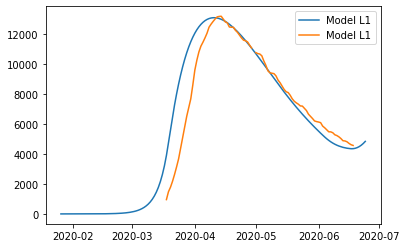

In [89]:
%matplotlib inline
plt.figure(1)
plt.plot(days_model, model_data_beds["total"], label="Model L1")
plt.plot(days_model, real_data_beds["total"], label="Model L1")
plt.legend(loc='upper right')

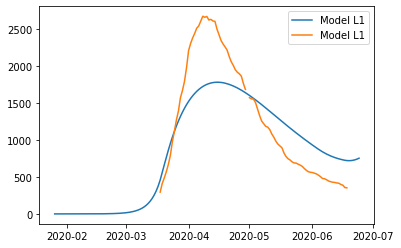

In [90]:
%matplotlib inline
plt.figure(1)
plt.plot(days_model, model_data_icus["total"], label="Model L1")
plt.plot(days_model, real_data_icus["total"], label="Model L1")
plt.legend(loc='upper right')

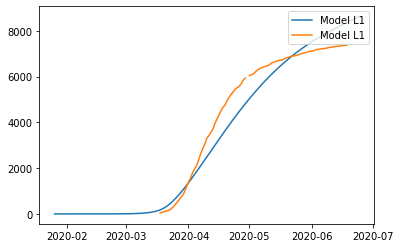

In [91]:
%matplotlib inline
plt.figure(1)
plt.plot(days_model, model_data_deaths["total"], label="Model L1")
plt.plot(days_model, real_data_deaths["total"], label="Model L1")
plt.legend(loc='upper right')

In [102]:
with open("../initialization/initialization.yaml") as file:
    initialization = yaml.load(file, Loader=yaml.FullLoader)
with open("../parameters/Ile-de-France.yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    universe_params = yaml.load(file, Loader=yaml.FullLoader)


In [103]:
ays_ahead = v[0]
alpha_mixing = v[1]
beta_mixing = v[2]
gamma_mixing = v[3]

dynModel.mu = np.array(v[4:13])
dynModel.sigma = np.array(v[13:22])
dynModel.p_H = np.array(v[22:31])
dynModel.p_ICU = np.array(v[31:40])
dynModel.lambda_H_R = np.array(v[40:49])
dynModel.lambda_H_D = np.array(v[49:58])
dynModel.lambda_ICU_R = np.array(v[58:67])
dynModel.lambda_ICU_D = np.array(v[67:76])

upper_bound = v[76]

delta_transport = v[77]
delta_work = v[78]
delta_school = v[79]

leisure_1 = v[80]
leisure_2 = v[81]
leisure_3 = v[82]
leisure_4 = v[83]
leisure_5 = v[84]
leisure_denom = leisure_1+leisure_2+leisure_3+leisure_4+leisure_5

other_1 = v[85]
other_2 = v[86]
other_3 = v[87]
other_4 = v[88]
other_5 = v[89]
other_denom = other_1+other_2+other_3+other_4+other_5

In [105]:
# Modify parameters
universe_params['mixing'] = {
    "name":"mult",
    "param_alpha":alpha_mixing,
    "param_beta":beta_mixing,
}
for i,age_group in enumerate(age_groups):
    universe_params['seir-groups'][age_group]['parameters']['beta'] = universe_params['seir-groups'][age_group]['parameters']['beta']*gamma_mixing
    universe_params['seir-groups'][age_group]['parameters']['mu'] = v[4+i]
    universe_params['seir-groups'][age_group]['parameters']['sigma'] = v[13+i]
    universe_params['seir-groups'][age_group]['parameters']['p_H'] = v[22+i]
    universe_params['seir-groups'][age_group]['parameters']['p_ICU'] = v[31+i]
    universe_params['seir-groups'][age_group]['parameters']['lambda_H_R'] = v[40+i]
    universe_params['seir-groups'][age_group]['parameters']['lambda_H_D'] = v[49+i]
    universe_params['seir-groups'][age_group]['parameters']['lambda_ICU_R'] = v[58+i]
    universe_params['seir-groups'][age_group]['parameters']['lambda_ICU_D'] = v[67+i]
    
with open('../parameters/fitted.yaml', 'w') as file:
    yaml.dump(universe_params, file)
    

In [107]:
# Add economic value parameters
contrib = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="contributions_normal", index_col = 0)
drops = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="activity_levels_as_%_of_full", index_col = 0)

empl_params = {}
empl_params["v"] = {}
for age_group in age_groups:
    empl_params["v"][age_group] = {}
    for activity in econ_activities:
        empl_params["v"][age_group][activity] = float(contrib[age_group][activity])/365.0


In [108]:
# Calculate l-april and l-may
l_april = a_between_date_1_2
l_may = {}
for a in a_between_date_1_2.keys():
    l_may[a] = a_between_date_1_2[a]/3.0 + a_between_date_2_3[a]*2.0/3.0

In [109]:
l_april

{'home': 0.984925391,
 'leisure': 0.02911777197632741,
 'other': 0.11455320515166358,
 'school': 0,
 'transport': 0.010853963467638622,
 'work': 0.11620826067947282}

In [110]:
l_may

{'home': 0.984925391,
 'leisure': 0.18858209267922665,
 'other': 0.14621578568939403,
 'school': 0.11745997287022852,
 'transport': 0.033767886343764604,
 'work': 0.3615368110028043}

In [73]:
from gurobipy import *
# Solve equations
empl_params["nu"] = {}
empl_params["eta"] = {}
empl_params["gamma"] = {}
for activity in econ_activities:
    m = Model()
    nu = m.addVar(vtype=GRB.CONTINUOUS, name="nu", lb = 0)
    eta = m.addVar(vtype=GRB.CONTINUOUS, name="eta", lb = 0)
    gamma = m.addVar(vtype=GRB.CONTINUOUS, name="gamma", lb = 0)
    epsilonp_1 = m.addVar(vtype=GRB.CONTINUOUS, name="epsilonp_1", lb = 0)
    epsilonn_1 = m.addVar(vtype=GRB.CONTINUOUS, name="epsilonn_1", lb = 0)
    epsilonp_2 = m.addVar(vtype=GRB.CONTINUOUS, name="epsilonp_2", lb = 0)
    epsilonn_2 = m.addVar(vtype=GRB.CONTINUOUS, name="epsilonn_2", lb = 0)
    
    m.addConstr(nu+eta+gamma==1)
    m.addConstr(
        nu*l_april["work"] + eta*l_april[activity] + gamma == drops[activity]["April"]+epsilonp_1-epsilonn_1
    )
    m.addConstr(
        nu*l_may["work"] + eta*l_may[activity] + gamma == drops[activity]["May"]+epsilonp_2-epsilonn_2
    )
    m.setObjective(epsilonp_1+epsilonn_1+epsilonp_2+epsilonn_2)
    m.update()
    m.optimize()
    empl_params["nu"][activity] = float(nu.x)
    empl_params["eta"][activity] = float(eta.x)
    empl_params["gamma"][activity] = float(gamma.x)
    


Using license file /Users/sergioacamelogomez/gurobi.lic
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 3 rows, 7 columns and 13 nonzeros
Model fingerprint: 0x241add63
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+00]
Presolve time: 0.00s
Presolved: 3 rows, 7 columns, 13 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.422549e-01   0.000000e+00      0s
       2    9.1741311e-02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.174131148e-02
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 3 rows, 7 columns and 13 nonzeros
Model fingerprint: 0x8ee73c76
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+0

In [111]:
from gurobipy import *
# Solve equations
empl_params["nu"] = {}
empl_params["eta"] = {}
empl_params["gamma"] = {}
for activity in econ_activities:
    A = np.array([
        [1,1,1],
        [l_april["work"],l_april[activity],1],
        [l_may["work"],l_may[activity],1]
    ])
    b = np.array([1,drops[activity]["April"],drops[activity]["May"]])
    print("Activity:",activity)
    print("A=",A)
    print("b=",b)
    print("nu,eta,gamma=",np.linalg.solve(A,b))
    print("")


Activity: transport
A= [[1.         1.         1.        ]
 [0.11620826 0.01085396 1.        ]
 [0.36153681 0.03376789 1.        ]]
b= [1.   0.61 0.81]
nu,eta,gamma= [ 0.84928217 -0.36454533  0.51526316]

Activity: leisure
A= [[1.         1.         1.        ]
 [0.11620826 0.02911777 1.        ]
 [0.36153681 0.18858209 1.        ]]
b= [1.    0.313 0.426]
nu,eta,gamma= [0.0016216  0.70612771 0.29225069]

Activity: other
A= [[1.         1.         1.        ]
 [0.11620826 0.11455321 1.        ]
 [0.36153681 0.14621579 1.        ]]
b= [1.    0.625 0.753]
nu,eta,gamma= [ 0.53615787 -0.11164069  0.57548283]



In [112]:
# Calculate the schooling parameter
r = 0.03
schooling_param = {}
for age_group in age_groups:
    if age_group == "age_group_0_9":
        schooling_param[age_group] = (1+r)**(-15)*sum([empl_params["v"]["age_group_20_29"][act] for act in econ_activities])
    elif age_group == "age_group_10_19":
        schooling_param[age_group] = 0.907*(1+r)**(-5)*sum([empl_params["v"]["age_group_20_29"][act] for act in econ_activities])
    else:
        schooling_param[age_group] = 0

In [113]:
# Calculate the cost of death
econ_cost_death = {}
age_groups_n = [0,10,20,30,40,50,60,70,80]
for i,age_group in enumerate(age_groups):
    s = 0
    for tao in range(age_groups_n[i]+5,70):
        ag = "age_group_%d_%d"%(int(tao/10)*10,int(tao/10)*10+9)
        s+=(1+r)**(-(tao-age_groups_n[i]))*sum([empl_params["v"][ag][act] for act in econ_activities])*365
    econ_cost_death[age_group] = float(s)

In [114]:
econ_params = {
    "employment_params":empl_params,
    "schooling_params":schooling_param,
    "econ_cost_death":econ_cost_death,
}
with open('../parameters/econ.yaml', 'w') as file:
    yaml.dump(econ_params, file)

In [115]:
print(econ_params)

{'employment_params': {'v': {'age_group_0_9': {'transport': 0.0, 'leisure': 0.0, 'other': 0.0}, 'age_group_10_19': {'transport': 0.42995936063784673, 'leisure': 0.7068903576182438, 'other': 4.574913439411911}, 'age_group_20_29': {'transport': 2.421870523023006, 'leisure': 3.981764503475539, 'other': 25.769523863503046}, 'age_group_30_39': {'transport': 5.3207402525299345, 'leisure': 8.74775693759741, 'other': 56.61448108213707}, 'age_group_40_49': {'transport': 6.5473065780407085, 'leisure': 10.764338009809762, 'other': 69.6655628368981}, 'age_group_50_59': {'transport': 6.717886370840974, 'leisure': 11.04478593529775, 'other': 71.48058969296267}, 'age_group_60_69': {'transport': 2.606993951947998, 'leisure': 4.286123424007397, 'other': 27.739299941136395}, 'age_group_70_79': {'transport': 0.0, 'leisure': 0.0, 'other': 0.0}, 'age_group_80_plus': {'transport': 0.0, 'leisure': 0.0, 'other': 0.0}}, 'nu': {}, 'eta': {}, 'gamma': {}}, 'schooling_params': {'age_group_0_9': 20.65072641904043,

In [116]:
# Initialization

# Run model
model_data = []
state = initial_state
model_data.append(np.sum(state[:,cont.index("H")]))

for t in range(days_before_date_1):
    state,_ = dynModel.take_time_step(state, tests, tests, alphas_to_matrix(alphas_vec[t]))
    model_data.append(np.sum(state[:,cont.index("H")]))


In [117]:
def matrix_to_state(m):
    state = {}
    for i,age_group in enumerate(age_groups):
        state[age_group] = {}
        for j,c in enumerate(cont):
            state[age_group][c] = float(m[i,j])
    return state

with open('../initialization/fitted.yaml', 'w') as file:
    yaml.dump(matrix_to_state(state), file)
    

In [ ]:
a_before_date_1 = {
    'home':upper_bound,
    'leisure':upper_bound,
    'other':upper_bound,
    'school':upper_bound,
    'transport':delta_transport*upper_bound,
    'work':upper_bound
}
a_between_date_1_2 = {
    'home':upper_bound,
    'leisure':leisure_1/leisure_denom*upper_bound,
    'other':other_1/other_denom*upper_bound,
    'school':0,
    'transport':delta_transport*0.24*delta_work*upper_bound,
    'work':0.24*delta_work*upper_bound
}
a_between_date_2_3 = {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2)/leisure_denom*upper_bound,
    'other':(other_1+other_2)/other_denom*upper_bound,
    'school':0.33*delta_school*upper_bound,
    'transport':delta_transport*delta_work*upper_bound,
    'work':delta_work*upper_bound
}
a_between_date_3_4 = {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2+leisure_3)/leisure_denom*upper_bound,
    'other':(other_1+other_2+other_3)/other_denom*upper_bound,
    'school':0.67*delta_school*upper_bound,
    'transport':delta_transport*delta_work*upper_bound,
    'work':delta_work*upper_bound
}
a_between_date_4_5 = {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
    'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
    'school':0.67*delta_school*upper_bound,
    'transport':delta_transport*delta_work*upper_bound,
    'work':delta_work*upper_bound
}
a_after_date_5 = {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
    'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
    'school':1.0*delta_school*upper_bound,
    'transport':delta_transport*delta_work*upper_bound,
    'work':delta_work*upper_bound
}


In [119]:
# Construct alphas
alphas = []

c = 0
# Alphas
for i in range(days_before_date_1):
    alphas.append( {
    'home':upper_bound,
    'leisure':upper_bound,
    'other':upper_bound,
    'school':upper_bound,
    'transport':delta_transport*upper_bound,
    'work':upper_bound,
    'date': (initial_date + timedelta(days=c)).strftime('%Y-%m-%d'),
    'days_from_lockdown':c-days_before_date_1
    })
    c+=1
for i in range(days_between_dates_1_2):
    alphas.append( {
    'home':upper_bound,
    'leisure':leisure_1/leisure_denom*upper_bound,
    'other':other_1/other_denom*upper_bound,
    'school':0,
    'transport':delta_transport*0.24*delta_work*upper_bound,
    'work':0.24*delta_work*upper_bound,
    'date': (initial_date + timedelta(days=c)).strftime('%Y-%m-%d'),
    'days_from_lockdown':c-days_before_date_1
    })
    c+=1
for i in range(days_between_dates_2_3):
    alphas.append( {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2)/leisure_denom*upper_bound,
    'other':(other_1+other_2)/other_denom*upper_bound,
    'school':0.33*delta_school*upper_bound,
    'transport':delta_transport*delta_work*upper_bound,
    'work':delta_work*upper_bound,
    'date': (initial_date + timedelta(days=c)).strftime('%Y-%m-%d'),
    'days_from_lockdown':c-days_before_date_1
    })
    c+=1
for i in range(days_between_dates_3_4):
    alphas.append( {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2+leisure_3)/leisure_denom*upper_bound,
    'other':(other_1+other_2+other_3)/other_denom*upper_bound,
    'school':0.67*delta_school*upper_bound,
    'transport':delta_transport*delta_work*upper_bound,
    'work':delta_work*upper_bound,
    'date': (initial_date + timedelta(days=c)).strftime('%Y-%m-%d'),
    'days_from_lockdown':c-days_before_date_1
    })
    c+=1
for i in range(days_between_dates_4_5):
    alphas.append( {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
    'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
    'school':0.67*delta_school*upper_bound,
    'transport':delta_transport*delta_work*upper_bound,
    'work':delta_work*upper_bound,
    'date': (initial_date + timedelta(days=c)).strftime('%Y-%m-%d'),
    'days_from_lockdown':c-days_before_date_1
    })
    c+=1
for i in range(days_after_date_5):
    alphas.append( {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
    'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
    'school':1.0*delta_school*upper_bound,
    'transport':delta_transport*delta_work*upper_bound,
    'work':delta_work*upper_bound,
    'date': (initial_date + timedelta(days=c)).strftime('%Y-%m-%d'),
    'days_from_lockdown':c-days_before_date_1
    })
    c+=1

with open('../policies/fitted.yaml', 'w') as file:
    yaml.dump(alphas, file)